In [1]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
sys.path.append(os.path.abspath('../scripts'))
from utility import read_csv_file, detect_outliers_iqr, analyze_handsets_data, find_high_correlation_pairs, calculate_decile, get_important_features, detect_outliers_iqr_and_replace_with_mean
from plot import plot_histograms, plot_boxplots, plot_bar_chart, plot_pie_chart, plot_stacked_bar, plot_correlation_heatmap

Read Dataset

In [3]:
data_path = '../data/Copy of Week2_challenge_data_source(CSV).csv'
telecom_data = read_csv_file(data_path)

In [4]:
telecom_data = telecom_data.get("data")
telecom_data.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [5]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [6]:
telecom_data.describe().T 

,count,mean,std,min,25%,50%,75%,max
Bearer Id,149010.0,1.013887e+19,2.893173e+18,6.917538e+18,7.349883e+18,7.349883e+18,1.304243e+19,1.318654e+19
Start ms,150000.0,4.991882e+02,2.886118e+02,0.000000e+00,2.500000e+02,4.990000e+02,7.490000e+02,9.990000e+02
End ms,150000.0,4.988009e+02,2.880977e+02,0.000000e+00,2.510000e+02,5.000000e+02,7.500000e+02,9.990000e+02
Dur. (ms),150000.0,1.046086e+05,8.103762e+04,7.142000e+03,5.744050e+04,8.639900e+04,1.324302e+05,1.859336e+06
IMSI,149431.0,2.082016e+14,2.148809e+10,2.040471e+14,2.082014e+14,2.082015e+14,2.082018e+14,2.140743e+14
MSISDN/Number,148935.0,4.188282e+10,2.447443e+12,3.360100e+10,3.365130e+10,3.366371e+10,3.368349e+10,8.823971e+14
IMEI,149429.0,4.847455e+13,2.241637e+13,4.400152e+11,3.546071e+13,3.572201e+13,8.611970e+13,9.900120e+13
Avg RTT DL (ms),122172.0,1.097957e+02,6.197827e+02,0.000000e+00,3.200000e+01,4.500000e+01,7.000000e+01,9.692300e+04
Avg RTT UL (ms),122189.0,1.766288e+01,8.479352e+01,0.000000e+00,2.000000e+00,5.000000e+00,1.500000e+01,7.120000e+03
Avg Bearer TP DL (kbps),150000.0,1.330005e+04,2.397188e+04,0.000000e+00,4.300000e+01,6.300000e+01,1.971075e+04,3.781600e+05


In [7]:
telecom_data.shape

(150001, 55)

In [8]:
telecom_data.isnull().sum()

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

Handle Missing Values

In [9]:

numerical_columns = [
    'Dur. (ms)', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 
    'Avg Bearer TP UL (kbps)', 
    'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 
    'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', 
    '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)', 'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 
    'Nb of sec with 125000B < Vol DL', 'Nb of sec with 1250B < Vol UL < 6250B', 
    'Nb of sec with 31250B < Vol DL < 125000B', 'Nb of sec with 37500B < Vol UL', 
    'Nb of sec with 6250B < Vol DL < 31250B', 'Nb of sec with 6250B < Vol UL < 37500B', 
    'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B'
]

# Impute missing numerical values with the median
telecom_data[numerical_columns] = telecom_data[numerical_columns].apply(lambda x: x.fillna(x.median()))


In [10]:
# List of categorical columns that need imputation
categorical_columns = [
    'IMEI','MSISDN/Number','IMSI','Handset Manufacturer', 'Handset Type', 'Last Location Name'
]

# Impute missing categorical values with the mode
telecom_data[categorical_columns] = telecom_data[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))


In [11]:
# List of time-related columns that need imputation
time_columns = ['Start', 'End', 'Start ms', 'End ms', 'Bearer Id']

# Impute missing time values with forward fill
telecom_data[time_columns] = telecom_data[time_columns].fillna(method='ffill')


/tmp/ipykernel_81300/2879128285.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  telecom_data[time_columns] = telecom_data[time_columns].fillna(method='ffill')


In [12]:
# For application data columns (e.g., HTTP, Social Media, YouTube, etc.)
# If missing, impute with mean
application_data_columns = [
    'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Social Media DL (Bytes)', 'Social Media UL (Bytes)',
    'Youtube DL (Bytes)','Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 
    'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)', 'Email UL (Bytes)', 
    'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)', 
    'Total UL (Bytes)', 'Total DL (Bytes)','TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)'
]

# Impute missing values with mean
telecom_data[application_data_columns] = telecom_data[application_data_columns].apply(lambda x: x.fillna(x.median()))


In [13]:

# Convert Identifiers to Python's native int type and then to string ( to avoid overflow )
telecom_data['Bearer Id'] = telecom_data['Bearer Id'].apply(lambda x: str(int(x)))
telecom_data['IMSI'] = telecom_data['IMSI'].apply(lambda x: str(int(x)))
telecom_data['MSISDN/Number'] = telecom_data['MSISDN/Number'].apply(lambda x: str(int(x)))
telecom_data['IMEI'] = telecom_data['IMEI'].apply(lambda x: str(int(x)))



In [15]:
telecom_data.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,208201448079117,33664962239,35521209507511,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,208201909211140,33681854413,35794009006359,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,208200314458056,33760627129,35281510359387,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,208201402342131,33750343200,35356610164913,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,208201401415120,33699795932,35407009745539,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [16]:
telecom_data.isna().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

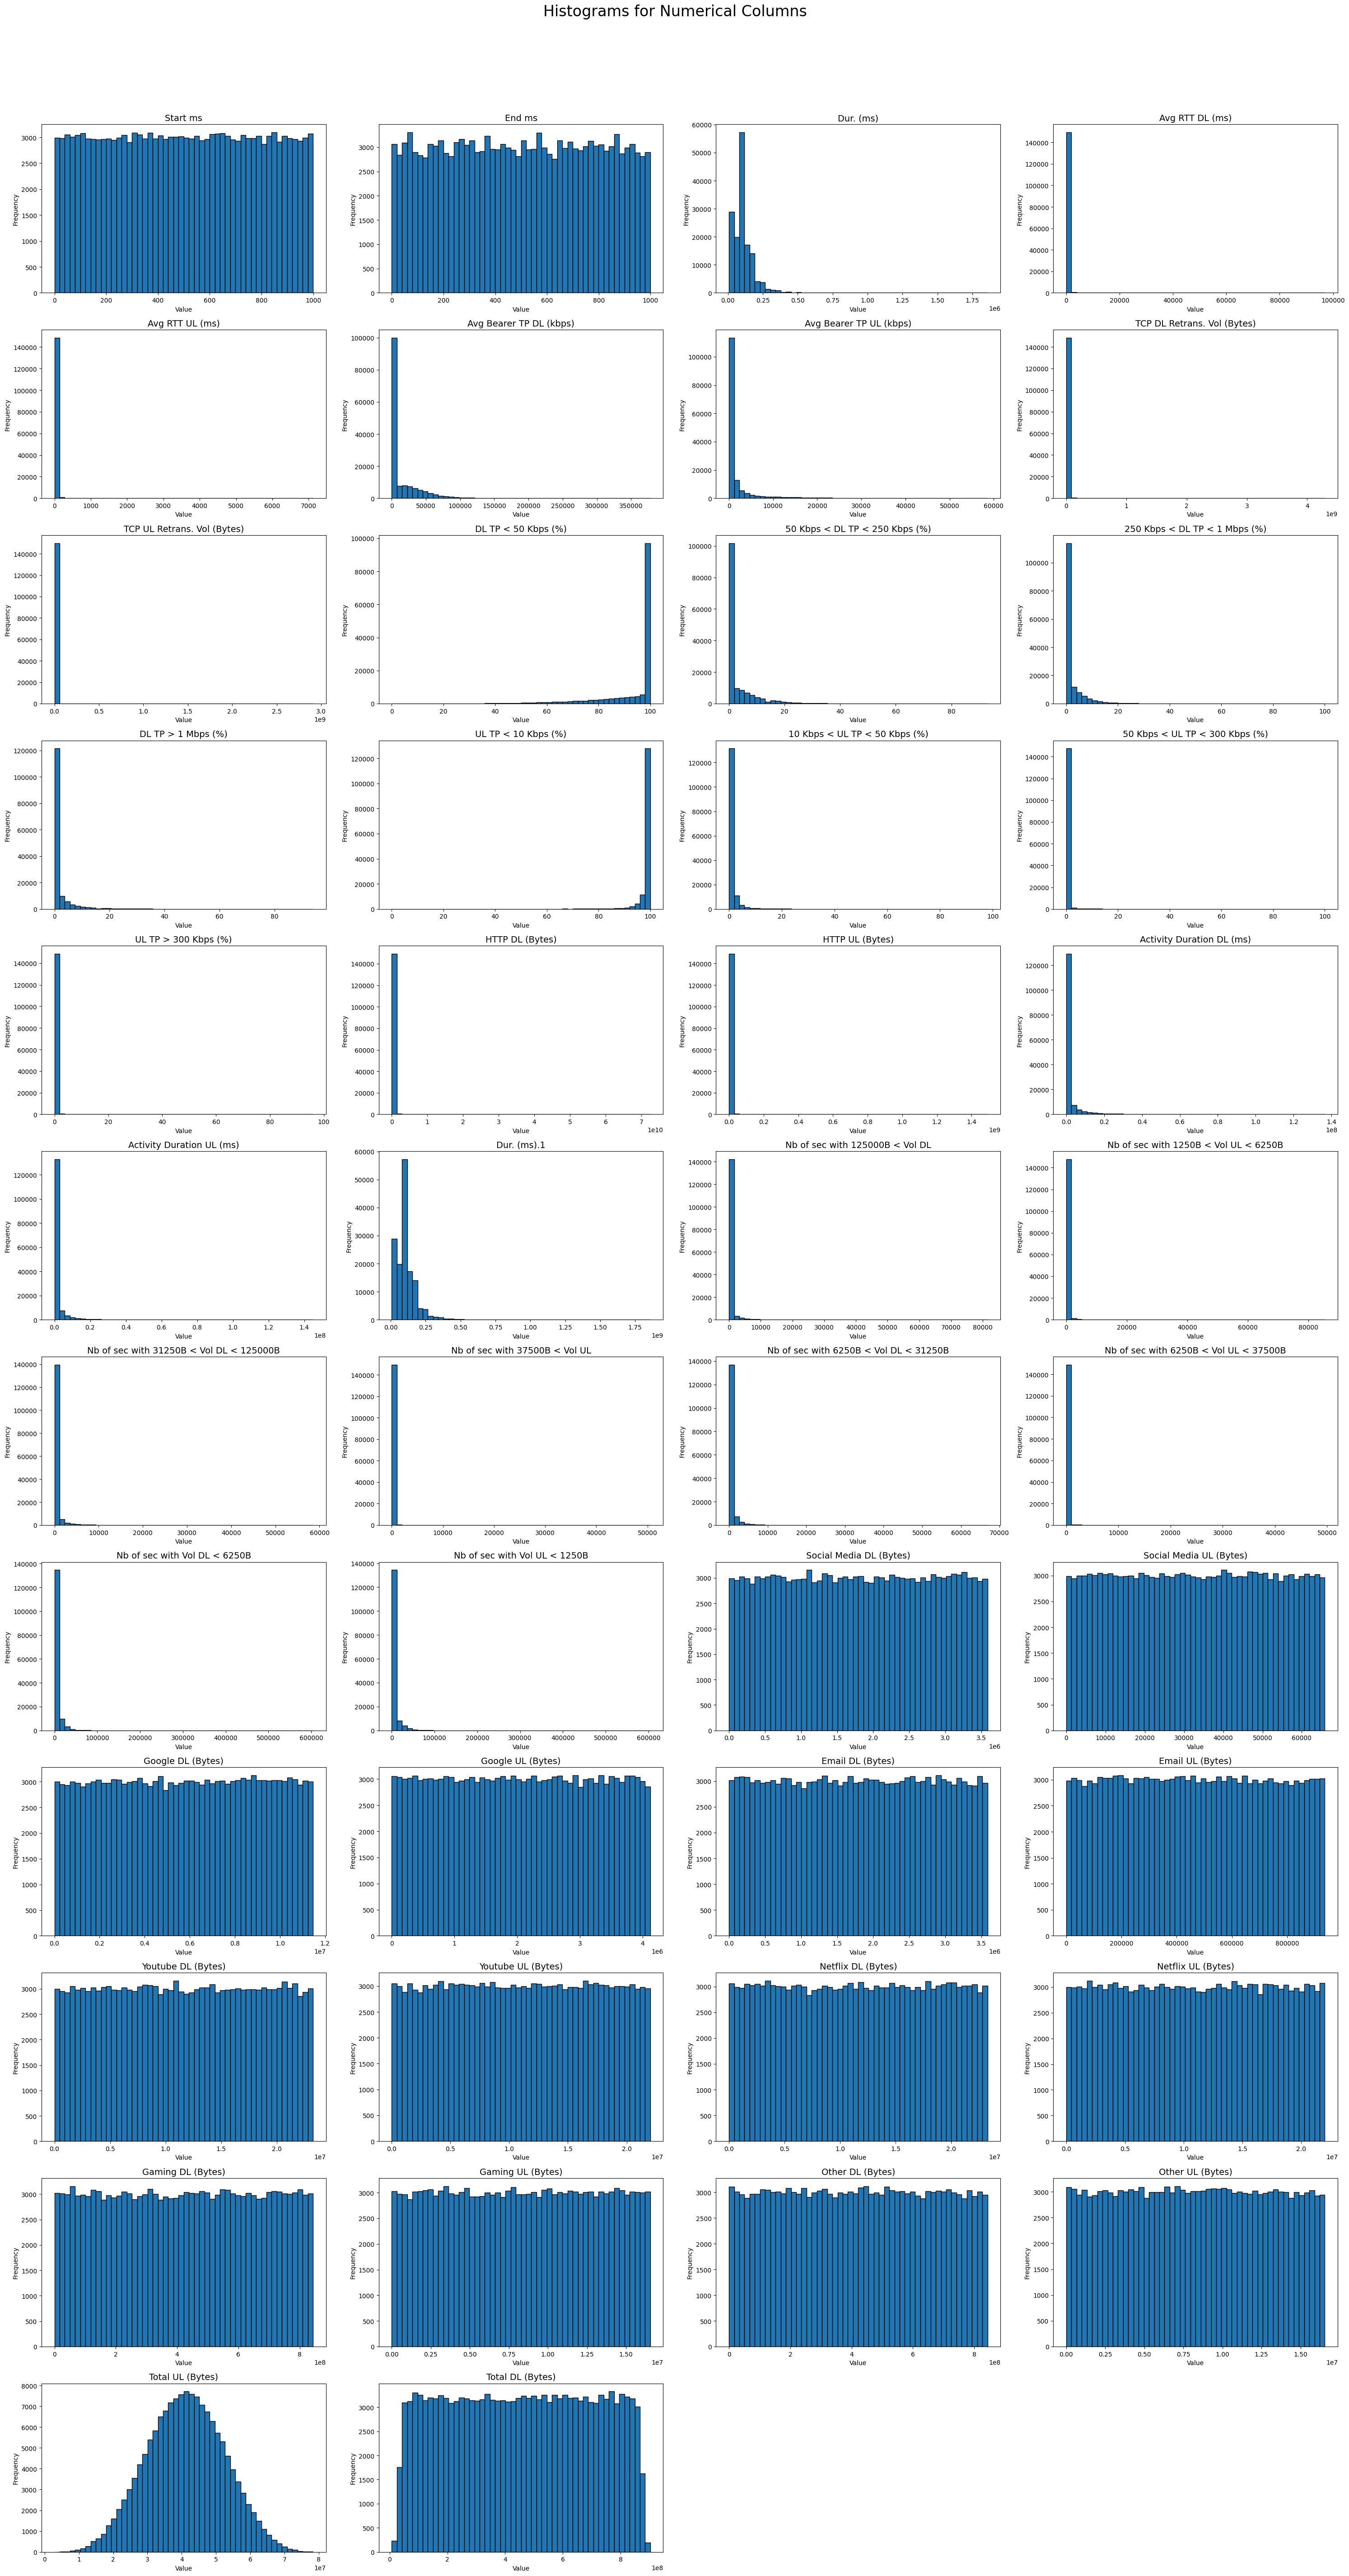

2024-12-25 22:56:40.839 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:56:51.597 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:56:53.659 
  command:

    streamlit run /home/samrawit/anaconda3/envs/kifiya/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-12-25 22:56:53.661 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [17]:
numerical_columns = telecom_data.select_dtypes(include=['float64', 'int64']).columns
plot_histograms(telecom_data, numerical_columns)

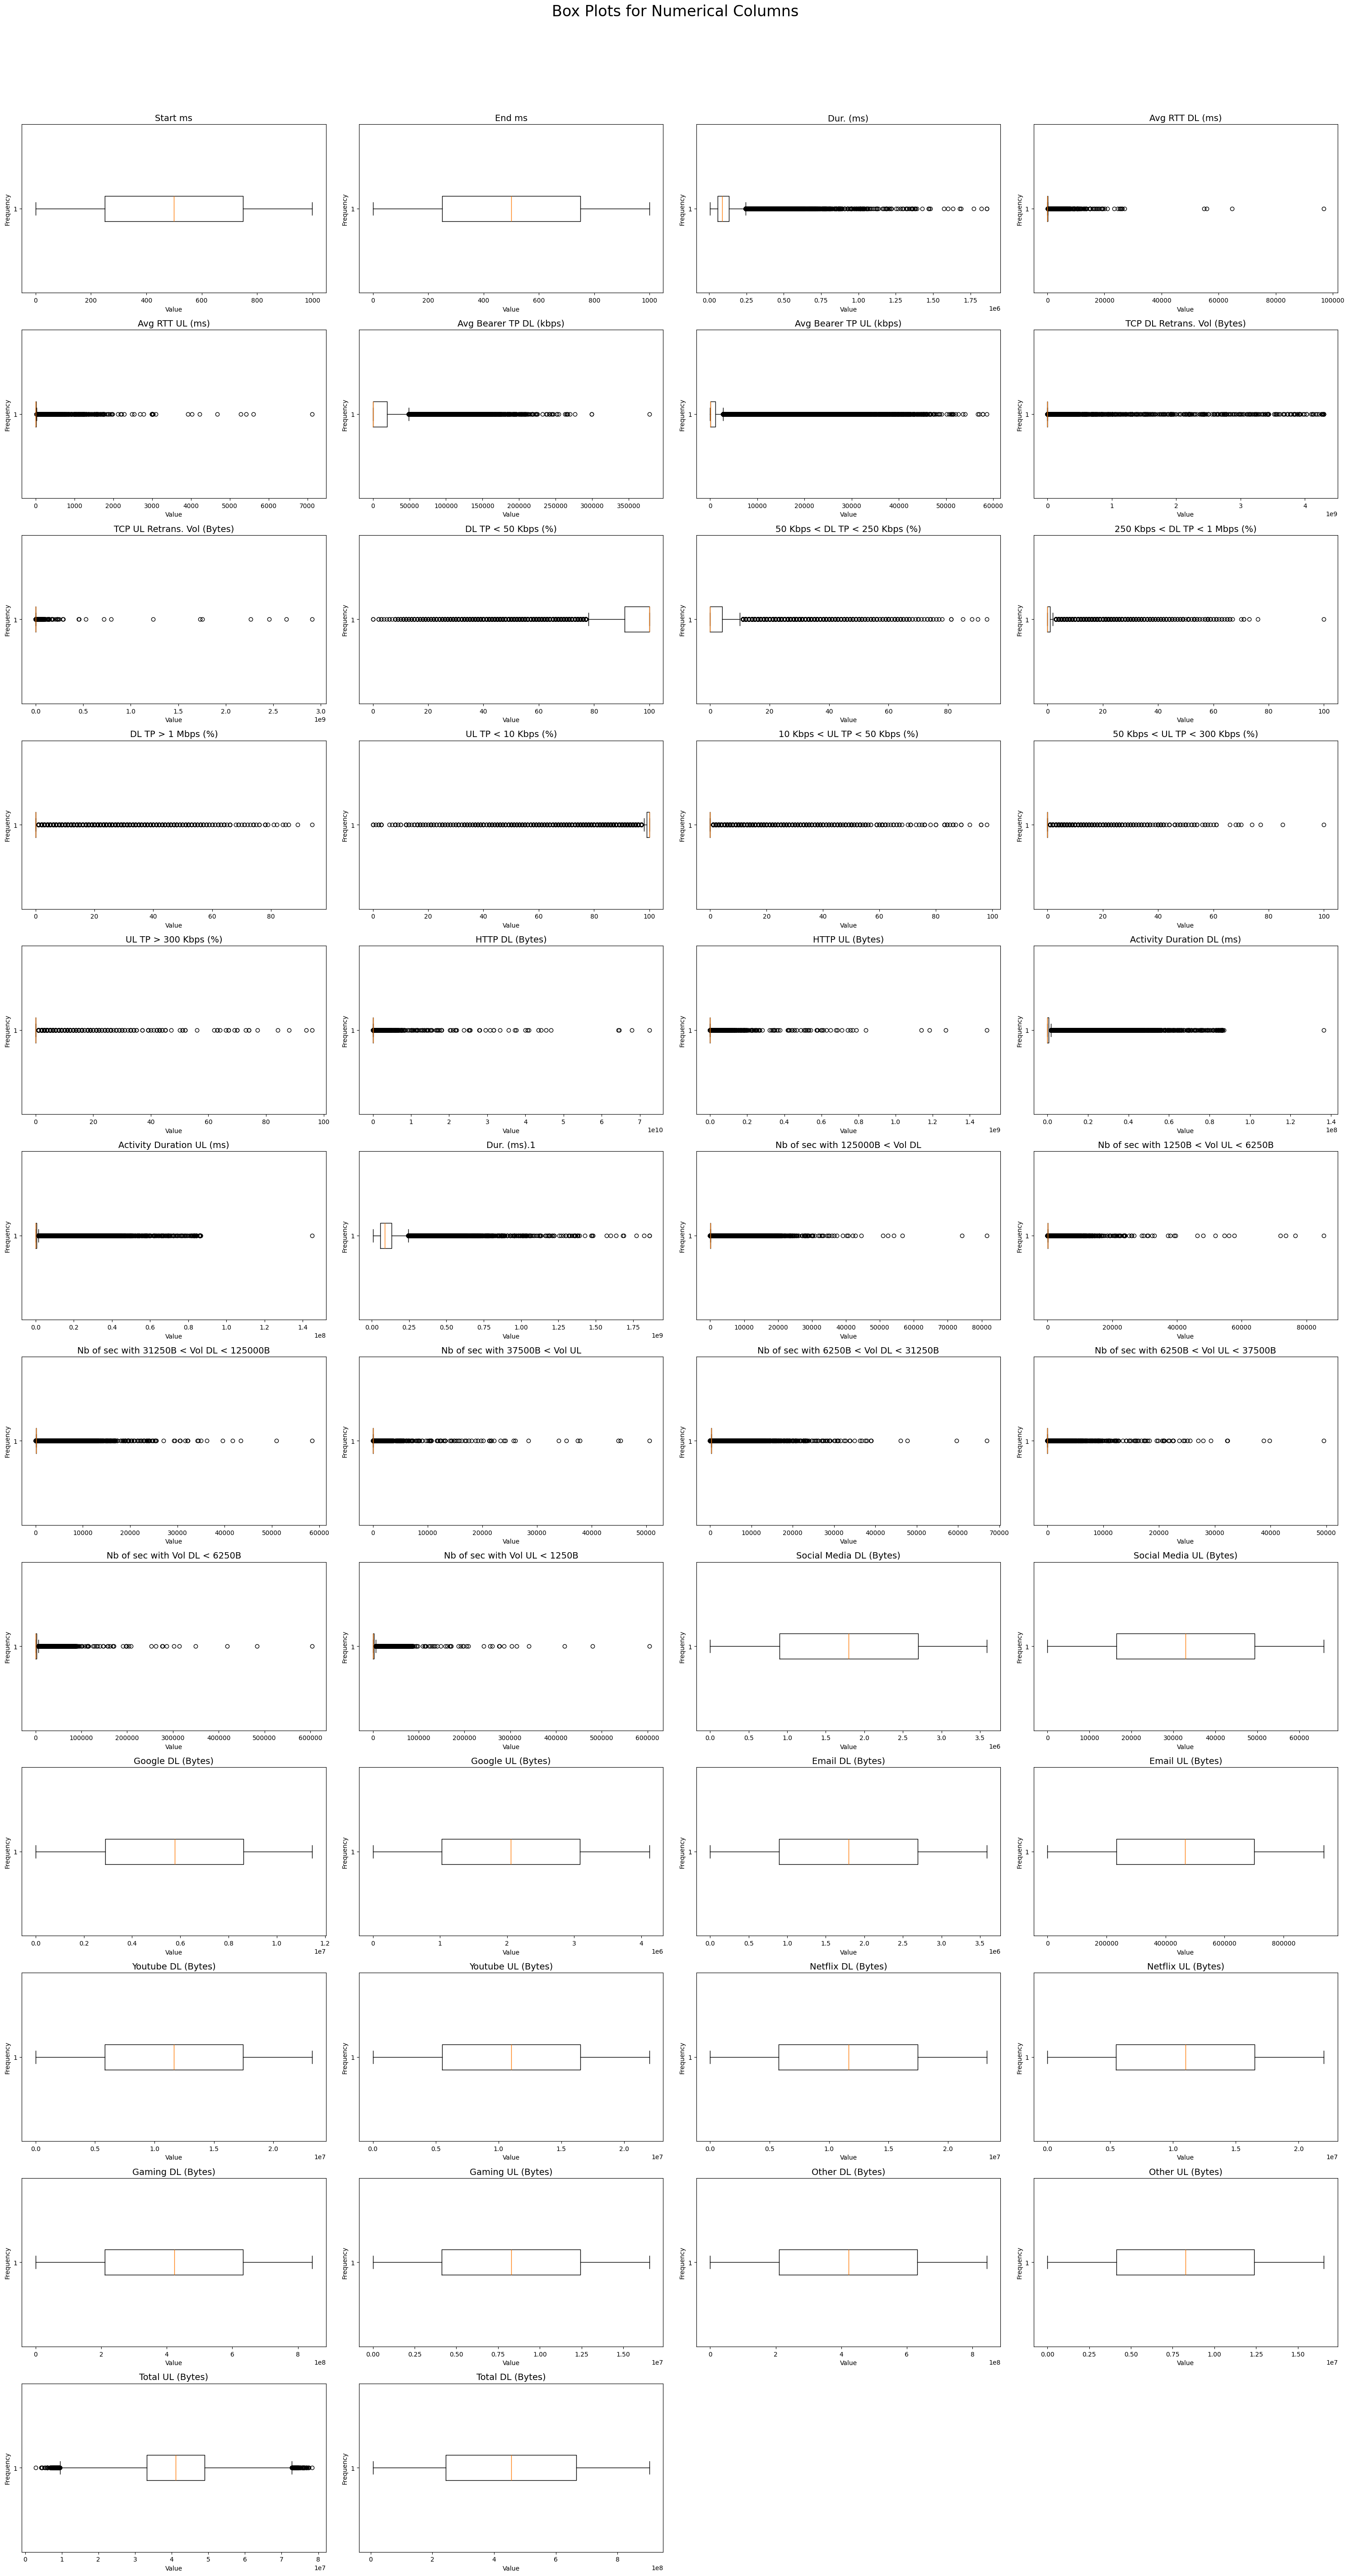

2024-12-25 22:57:26.248 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:57:35.989 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:57:35.990 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [18]:
numerical_columns = telecom_data.select_dtypes(include=['float64', 'int64']).columns
plot_boxplots(telecom_data, numerical_columns)

Get the MSIN number of the outliers

In [19]:

# Automatically detect numerical columns
numerical_columns = telecom_data.select_dtypes(include=['float64']).columns  

# Call the function and get outlier IMSI
outlier_imsis = detect_outliers_iqr(telecom_data, numerical_columns, id_col='IMSI')

# Print the list of outlier IMSIs
print(f'Outlier IMSIs: {outlier_imsis}')

len(outlier_imsis)


Column: Start ms - Number of outliers: 0
Lower bound: 0 & Upper bound: 1497.5

Column: End ms - Number of outliers: 0
Lower bound: 0 & Upper bound: 1498.5

Column: Dur. (ms) - Number of outliers: 7184
Lower bound: 0 & Upper bound: 244912.0

Column: Avg RTT DL (ms) - Number of outliers: 17792
Lower bound: 0 & Upper bound: 102.5

Column: Avg RTT UL (ms) - Number of outliers: 20116
Lower bound: 0 & Upper bound: 23.0

Column: Avg Bearer TP DL (kbps) - Number of outliers: 13235
Lower bound: 0 & Upper bound: 49210.5

Column: Avg Bearer TP UL (kbps) - Number of outliers: 21531
Lower bound: 0 & Upper bound: 2729.5

Column: TCP DL Retrans. Vol (Bytes) - Number of outliers: 30927
Lower bound: 0 & Upper bound: 568730.0

Column: TCP UL Retrans. Vol (Bytes) - Number of outliers: 26676
Lower bound: 0 & Upper bound: 20949.5

Column: DL TP < 50 Kbps (%) - Number of outliers: 0
Lower bound: 0 & Upper bound: 113.5

Column: 50 Kbps < DL TP < 250 Kbps (%) - Number of outliers: 15220
Lower bound: 0 & Upper

53430

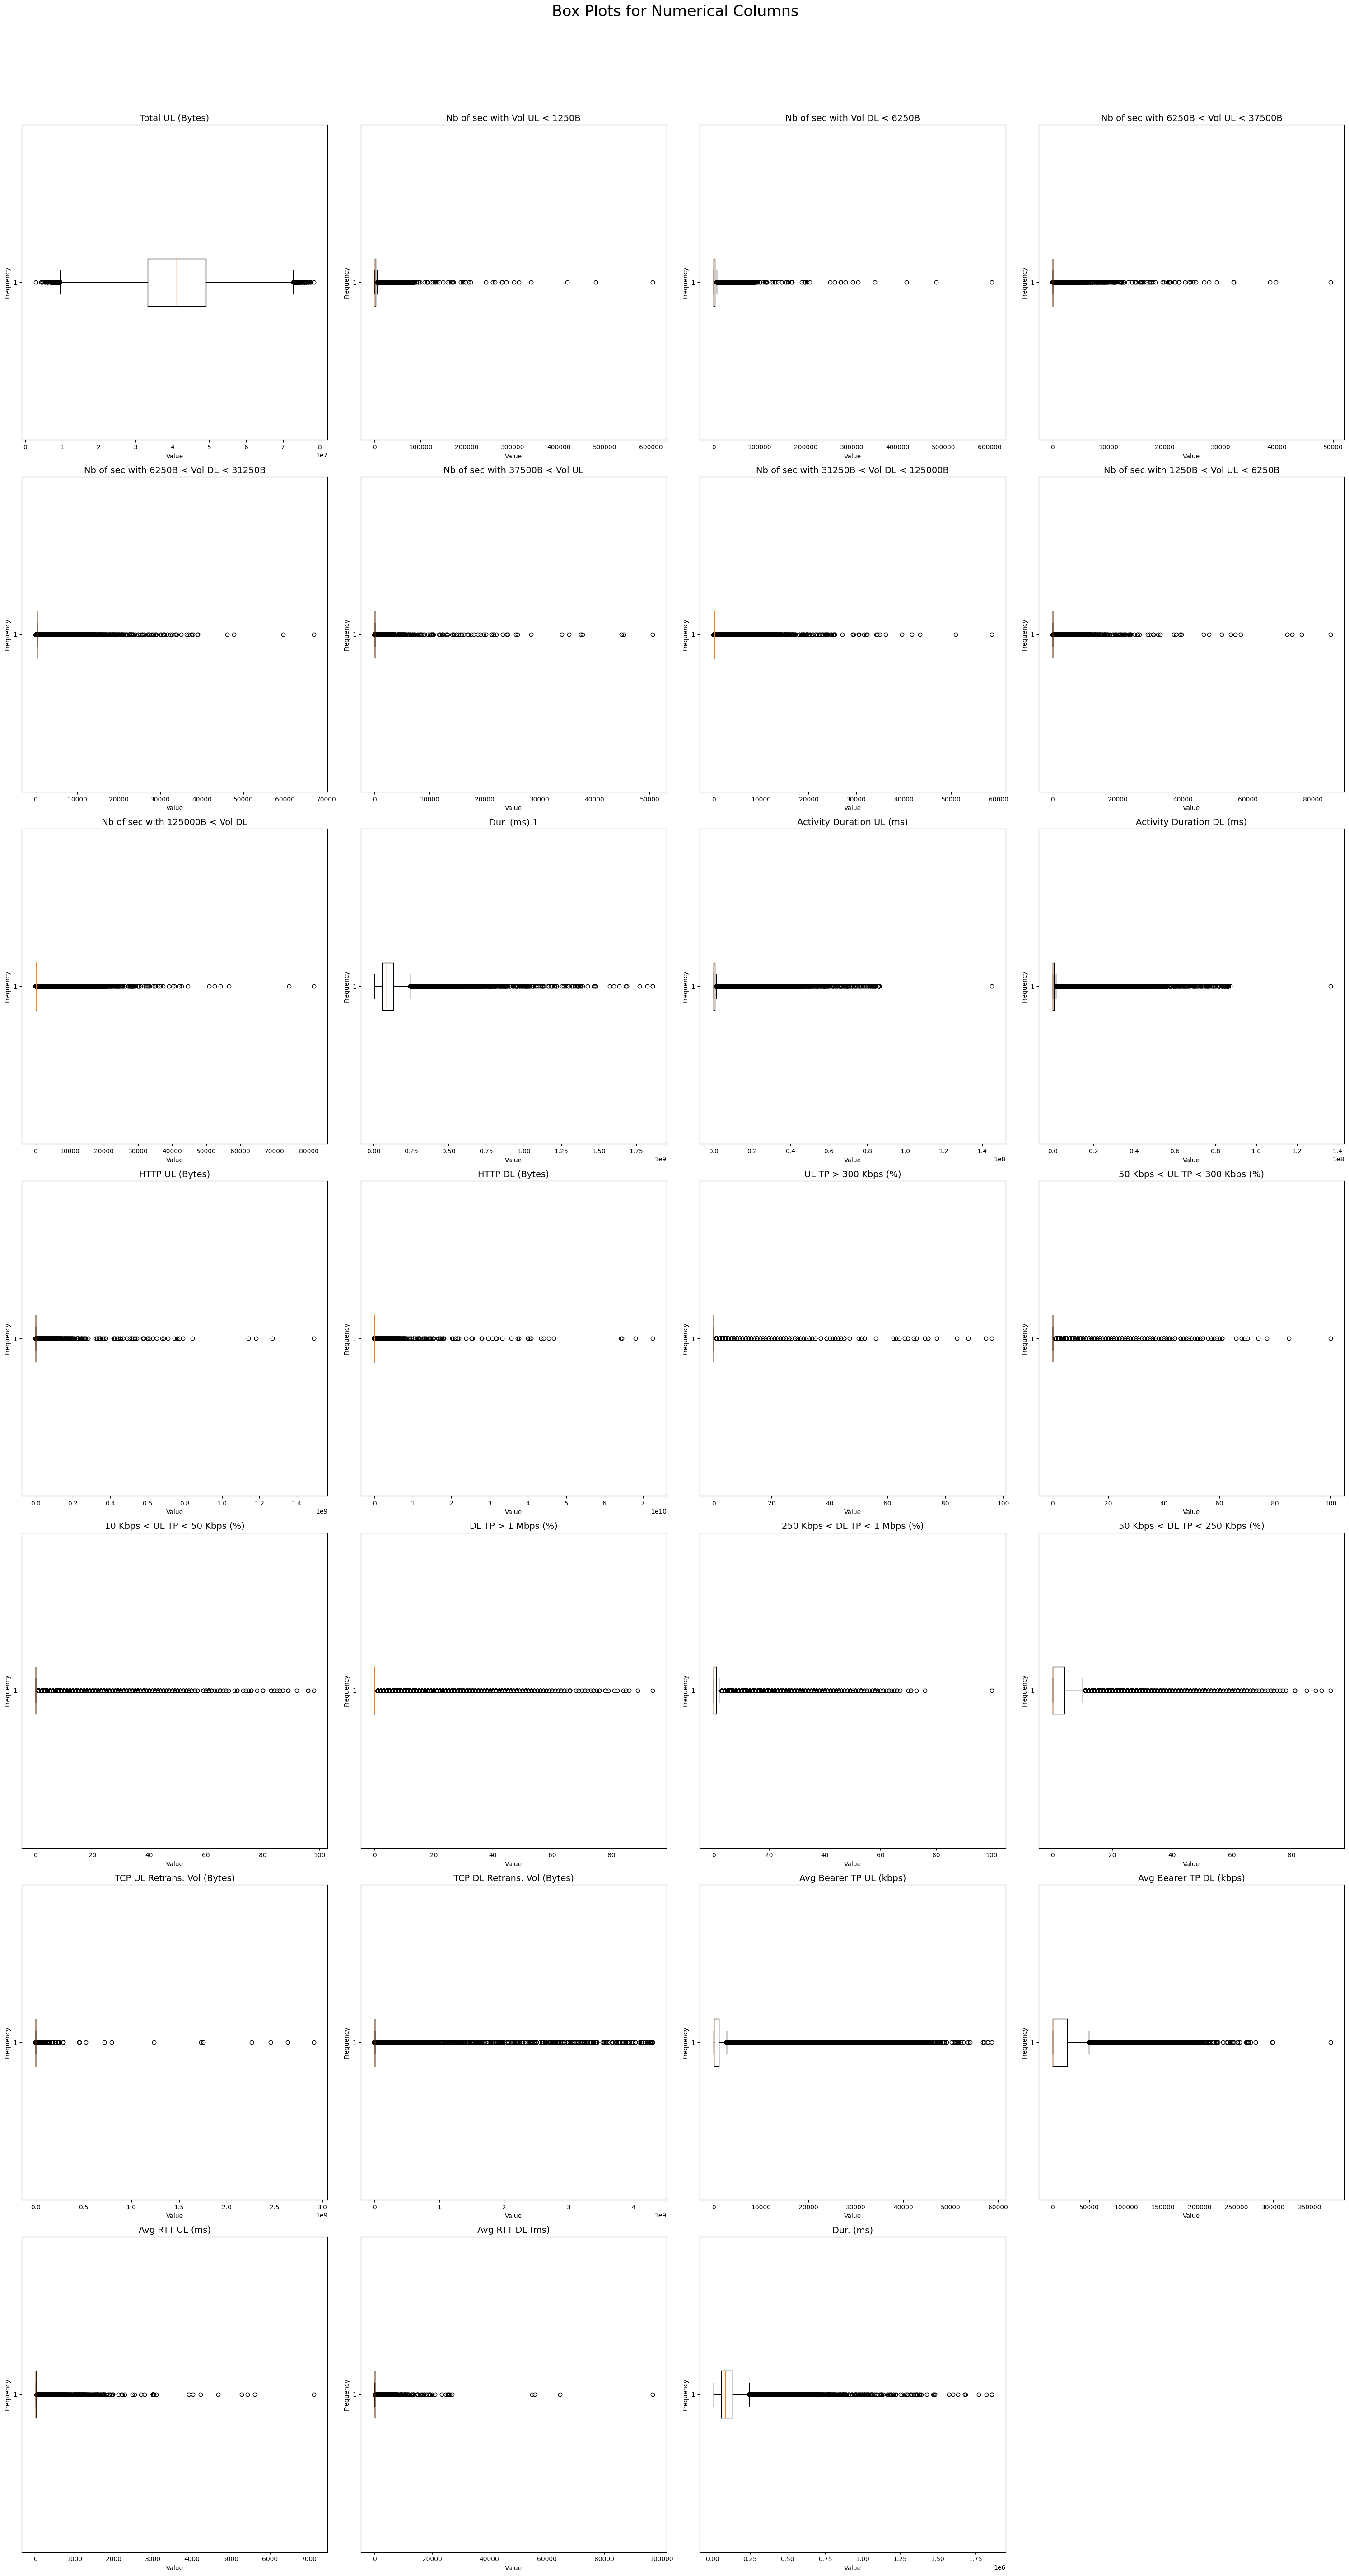

2024-12-25 22:57:49.648 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:57:57.373 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:57:57.374 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [20]:
# List of columns to draw box plots according to the above result
columns_to_plot = [
    "Total UL (Bytes)",
    "Nb of sec with Vol UL < 1250B",
    "Nb of sec with Vol DL < 6250B",
    "Nb of sec with 6250B < Vol UL < 37500B",
    "Nb of sec with 6250B < Vol DL < 31250B",
    "Nb of sec with 37500B < Vol UL",
    "Nb of sec with 31250B < Vol DL < 125000B",
    "Nb of sec with 1250B < Vol UL < 6250B",
    "Nb of sec with 125000B < Vol DL",
    "Dur. (ms).1",
    "Activity Duration UL (ms)",
    "Activity Duration DL (ms)",
    "HTTP UL (Bytes)",
    "HTTP DL (Bytes)",
    "UL TP > 300 Kbps (%)",
    "50 Kbps < UL TP < 300 Kbps (%)",
    "10 Kbps < UL TP < 50 Kbps (%)",
    "DL TP > 1 Mbps (%)",
    "250 Kbps < DL TP < 1 Mbps (%)",
    "50 Kbps < DL TP < 250 Kbps (%)",
    "TCP UL Retrans. Vol (Bytes)",
    "TCP DL Retrans. Vol (Bytes)",
    "Avg Bearer TP UL (kbps)",
    "Avg Bearer TP DL (kbps)",
    "Avg RTT UL (ms)",
    "Avg RTT DL (ms)",
    "Dur. (ms)"
]

# Call the plot_boxplots function
plot_boxplots(telecom_data, columns_to_plot)


In [22]:
telecom_data = detect_outliers_iqr_and_replace_with_mean(telecom_data, columns_to_plot, id_col="MSISDN/Number")


Column: Total UL (Bytes) - Number of outliers replaced with mean: 125
Lower bound: 0 & Upper bound: 72752551.5

Column: Nb of sec with Vol UL < 1250B - Number of outliers replaced with mean: 25389
Lower bound: 0 & Upper bound: 5882.0

Column: Nb of sec with Vol DL < 6250B - Number of outliers replaced with mean: 24785
Lower bound: 0 & Upper bound: 6388.0

Column: Nb of sec with 6250B < Vol UL < 37500B - Number of outliers replaced with mean: 18991
Lower bound: 0 & Upper bound: 8.0

Column: Nb of sec with 6250B < Vol DL < 31250B - Number of outliers replaced with mean: 30829
Lower bound: 0 & Upper bound: 288.0

Column: Nb of sec with 37500B < Vol UL - Number of outliers replaced with mean: 9824
Lower bound: 0 & Upper bound: 8.0

Column: Nb of sec with 31250B < Vol DL < 125000B - Number of outliers replaced with mean: 28174
Lower bound: 0 & Upper bound: 164.0

Column: Nb of sec with 1250B < Vol UL < 6250B - Number of outliers replaced with mean: 28489
Lower bound: 0 & Upper bound: 52.0



In [23]:
telecom_data = detect_outliers_iqr_and_replace_with_mean(telecom_data, columns_to_plot, id_col="IMSI")


Column: Total UL (Bytes) - Number of outliers replaced with mean: 6
Lower bound: 0 & Upper bound: 72680379.0

Column: Nb of sec with Vol UL < 1250B - Number of outliers replaced with mean: 0
Lower bound: 0 & Upper bound: 5882.0

Column: Nb of sec with Vol DL < 6250B - Number of outliers replaced with mean: 0
Lower bound: 0 & Upper bound: 6388.0

Column: Nb of sec with 6250B < Vol UL < 37500B - Number of outliers replaced with mean: 18991
Lower bound: 0 & Upper bound: 8.0

Column: Nb of sec with 6250B < Vol DL < 31250B - Number of outliers replaced with mean: 30829
Lower bound: 0 & Upper bound: 288.0

Column: Nb of sec with 37500B < Vol UL - Number of outliers replaced with mean: 9824
Lower bound: 0 & Upper bound: 8.0

Column: Nb of sec with 31250B < Vol DL < 125000B - Number of outliers replaced with mean: 28174
Lower bound: 0 & Upper bound: 164.0

Column: Nb of sec with 1250B < Vol UL < 6250B - Number of outliers replaced with mean: 28489
Lower bound: 0 & Upper bound: 52.0

Column: Nb

In [24]:
telecom_data = detect_outliers_iqr_and_replace_with_mean(telecom_data, columns_to_plot, id_col="Bearer Id")


Column: Total UL (Bytes) - Number of outliers replaced with mean: 1
Lower bound: 0 & Upper bound: 72674234.0

Column: Nb of sec with Vol UL < 1250B - Number of outliers replaced with mean: 0
Lower bound: 0 & Upper bound: 5882.0

Column: Nb of sec with Vol DL < 6250B - Number of outliers replaced with mean: 0
Lower bound: 0 & Upper bound: 6388.0

Column: Nb of sec with 6250B < Vol UL < 37500B - Number of outliers replaced with mean: 18991
Lower bound: 0 & Upper bound: 8.0

Column: Nb of sec with 6250B < Vol DL < 31250B - Number of outliers replaced with mean: 30829
Lower bound: 0 & Upper bound: 288.0

Column: Nb of sec with 37500B < Vol UL - Number of outliers replaced with mean: 9824
Lower bound: 0 & Upper bound: 8.0

Column: Nb of sec with 31250B < Vol DL < 125000B - Number of outliers replaced with mean: 28174
Lower bound: 0 & Upper bound: 164.0

Column: Nb of sec with 1250B < Vol UL < 6250B - Number of outliers replaced with mean: 28489
Lower bound: 0 & Upper bound: 52.0

Column: Nb

In [25]:
telecom_data = detect_outliers_iqr_and_replace_with_mean(telecom_data, columns_to_plot, id_col="IMEI")


Column: Total UL (Bytes) - Number of outliers replaced with mean: 0
Lower bound: 0 & Upper bound: 72673636.5

Column: Nb of sec with Vol UL < 1250B - Number of outliers replaced with mean: 0
Lower bound: 0 & Upper bound: 5882.0

Column: Nb of sec with Vol DL < 6250B - Number of outliers replaced with mean: 0
Lower bound: 0 & Upper bound: 6388.0

Column: Nb of sec with 6250B < Vol UL < 37500B - Number of outliers replaced with mean: 0
Lower bound: 0 & Upper bound: 8.0

Column: Nb of sec with 6250B < Vol DL < 31250B - Number of outliers replaced with mean: 0
Lower bound: 0 & Upper bound: 350.15900065096105

Column: Nb of sec with 37500B < Vol UL - Number of outliers replaced with mean: 0
Lower bound: 0 & Upper bound: 8.0

Column: Nb of sec with 31250B < Vol DL < 125000B - Number of outliers replaced with mean: 0
Lower bound: 0 & Upper bound: 191.46821205528863

Column: Nb of sec with 1250B < Vol UL < 6250B - Number of outliers replaced with mean: 0
Lower bound: 0 & Upper bound: 58.536985

In [26]:
telecom_data.to_csv('../data/preprocessed.csv', index=False)

In [27]:
top_10_handsets, top_3_manufacturers, top_5_handsets_per_manufacturer = analyze_handsets_data(telecom_data)

# Display results
print("Top 10 Handsets:")
print(top_10_handsets)
print("\nTop 3 Handset Manufacturers:")
print(top_3_manufacturers)
print("\nTop 5 Handsets per Top 3 Handset Manufacturers:")
for manufacturer, handsets in top_5_handsets_per_manufacturer.items():
    print(f"\nManufacturer: {manufacturer}")
    print(handsets)


Top 10 Handsets:
Handset Type
Huawei B528S-23A                20324
Apple iPhone 6S (A1688)          9419
Apple iPhone 6 (A1586)           9023
undefined                        8987
Apple iPhone 7 (A1778)           6326
Apple iPhone Se (A1723)          5187
Apple iPhone 8 (A1905)           4993
Apple iPhone Xr (A2105)          4568
Samsung Galaxy S8 (Sm-G950F)     4520
Apple iPhone X (A1901)           3813
Name: count, dtype: int64

Top 3 Handset Manufacturers:
Handset Manufacturer
Apple      60137
Samsung    40839
Huawei     34423
Name: count, dtype: int64

Top 5 Handsets per Top 3 Handset Manufacturers:

Manufacturer: Apple
Handset Type
Apple iPhone 6S (A1688)    9419
Apple iPhone 6 (A1586)     9023
Apple iPhone 7 (A1778)     6326
Apple iPhone Se (A1723)    5187
Apple iPhone 8 (A1905)     4993
Name: count, dtype: int64

Manufacturer: Samsung
Handset Type
Samsung Galaxy S8 (Sm-G950F)    4520
Samsung Galaxy A5 Sm-A520F      3724
Samsung Galaxy J5 (Sm-J530)     3696
Samsung Galaxy J3 (S

/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:340: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.values, y=data.index.astype(str), palette=color_palette, ax=ax)


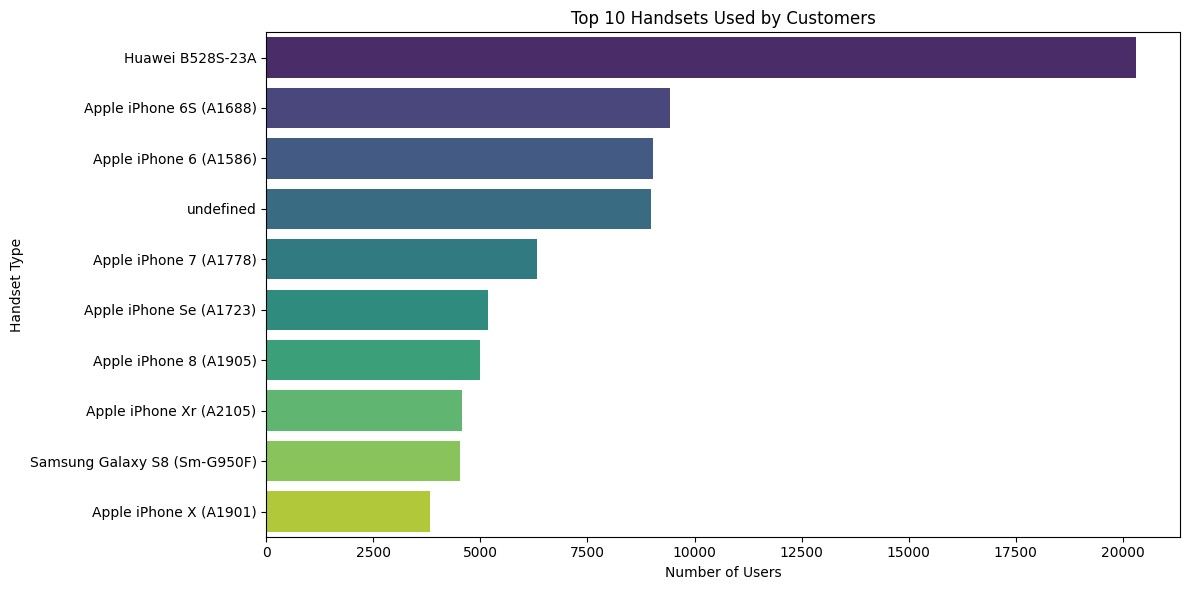

2024-12-25 22:58:37.593 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:58:38.038 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:58:38.039 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


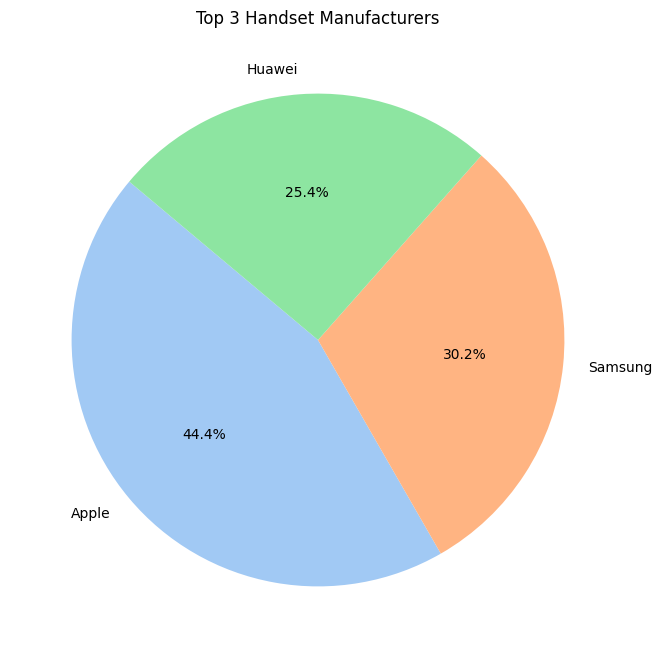

2024-12-25 22:58:38.254 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:58:38.400 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:58:38.400 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:340: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.values, y=data.index.astype(str), palette=color_palette, ax=ax)


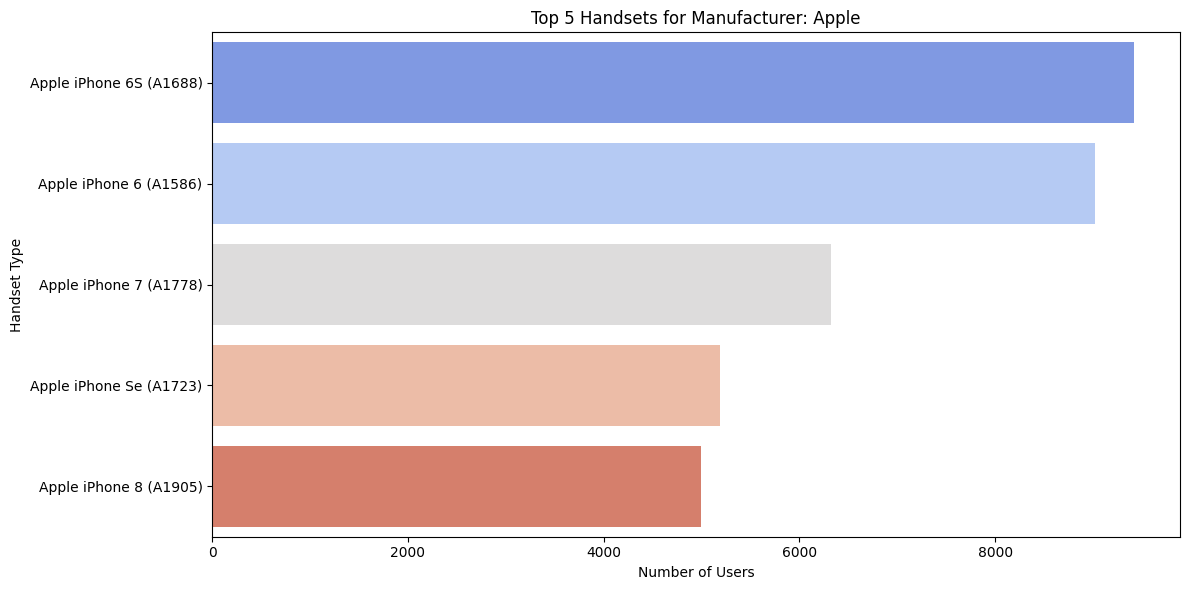

2024-12-25 22:58:38.611 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:58:38.933 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:58:38.934 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:340: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.values, y=data.index.astype(str), palette=color_palette, ax=ax)


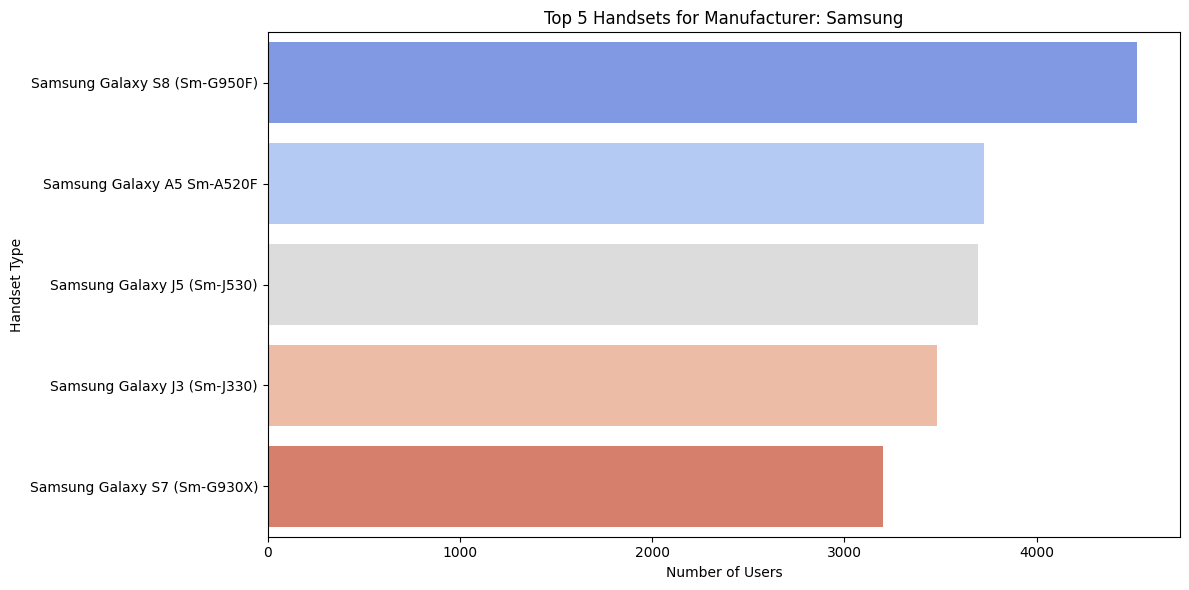

2024-12-25 22:58:39.184 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:58:39.540 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:58:39.541 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:340: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.values, y=data.index.astype(str), palette=color_palette, ax=ax)


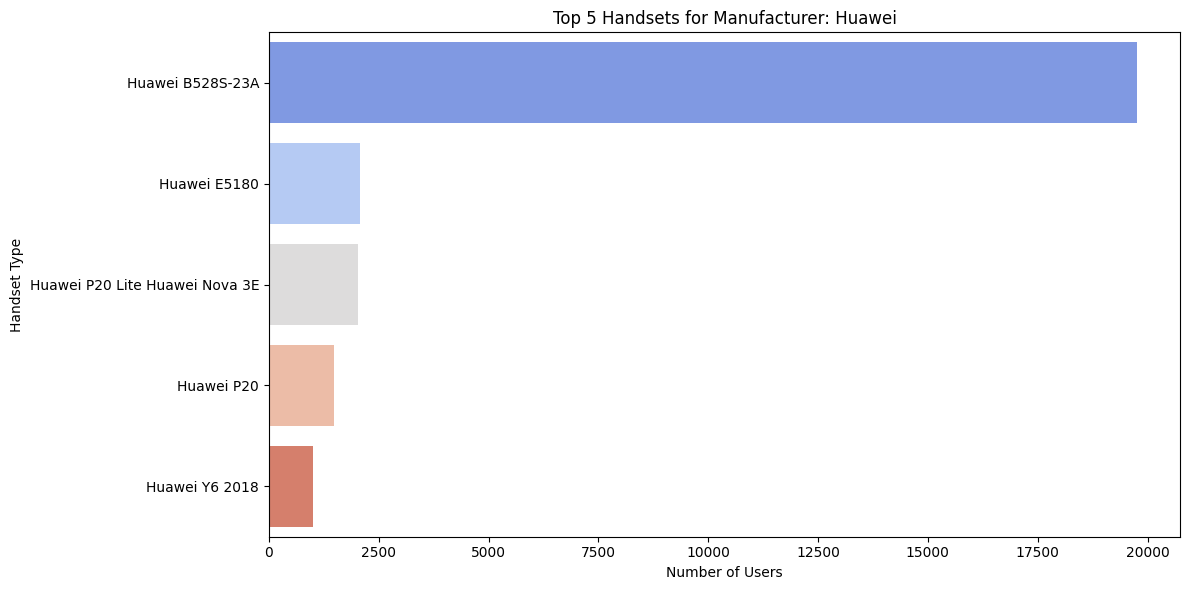

2024-12-25 22:58:39.755 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:58:40.093 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:58:40.094 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [28]:
# Analyze handset data
top_10_handsets, top_3_manufacturers, top_5_handsets_per_manufacturer = analyze_handsets_data(telecom_data)

# Plotting Bar Chart for Top 10 Handsets
plot_bar_chart(
    data=top_10_handsets, 
    x_col='Handset_Type', 
    y_col='Number_of_Users',
    title="Top 10 Handsets Used by Customers", 
    x_label="Handset Type", 
    y_label="Number of Users", 
    color_palette="viridis", 
    horizontal=True
)

# Plotting Pie Chart for Top 3 Manufacturers
plot_pie_chart(
    top_3_manufacturers, 
    title="Top 3 Handset Manufacturers", 
    colors=sns.color_palette("pastel")[:3]
)

# Loop through manufacturers to plot top 5 handsets for each
for manufacturer, handsets in top_5_handsets_per_manufacturer.items():
    plot_bar_chart(
        data=handsets,  
        x_col='Handset_Type', 
        y_col='Number_of_Users',
        title=f"Top 5 Handsets for Manufacturer: {manufacturer}", 
        x_label="Handset Type", 
        y_label="Number of Users", 
        color_palette="coolwarm", 
        horizontal=True
    )

User Behavior Overview

In [29]:
# Add total data volume column
telecom_data['Total Data Volume (Bytes)'] = telecom_data['Total DL (Bytes)'] + telecom_data['Total UL (Bytes)']

# Aggregating per user
aggregated_data = telecom_data.groupby('IMSI').agg(
    Number_of_xDR_Sessions=('Bearer Id', 'nunique'),
    Total_Session_Duration=('Dur. (ms)', 'sum'),
    Total_Download_Data=('Total DL (Bytes)', 'sum'),
    Total_Upload_Data=('Total UL (Bytes)', 'sum'),
    Total_Data_Volume=('Total Data Volume (Bytes)', 'sum'),
    Social_Media_DL=('Social Media DL (Bytes)', 'sum'),
    Social_Media_UL=('Social Media UL (Bytes)', 'sum'),
    Google_DL=('Google DL (Bytes)', 'sum'),
    Google_UL=('Google UL (Bytes)', 'sum'),
    Email_DL=('Email DL (Bytes)', 'sum'),
    Email_UL=('Email UL (Bytes)', 'sum'),
    Youtube_DL=('Youtube DL (Bytes)', 'sum'),
    Youtube_UL=('Youtube UL (Bytes)', 'sum'),
    Netflix_DL=('Netflix DL (Bytes)', 'sum'),
    Netflix_UL=('Netflix UL (Bytes)', 'sum'),
    Gaming_DL=('Gaming DL (Bytes)', 'sum'),
    Gaming_UL=('Gaming UL (Bytes)', 'sum'),
    Other_DL=('Other DL (Bytes)', 'sum'),
    Other_UL=('Other UL (Bytes)', 'sum')
).reset_index()

# Display the aggregated data
aggregated_data.head(10)


,IMSI,Number_of_xDR_Sessions,Total_Session_Duration,Total_Download_Data,Total_Upload_Data,Total_Data_Volume,Social_Media_DL,Social_Media_UL,Google_DL,Google_UL,Email_DL,Email_UL,Youtube_DL,Youtube_UL,Netflix_DL,Netflix_UL,Gaming_DL,Gaming_UL,Other_DL,Other_UL
0,204047108489451,1,104608.438950,78697597.0,60456049.0,1.391536e+08,1500145.0,45943.0,5985089.0,3233558.0,2518425.0,812549.0,18980320.0,21960390.0,21621336.0,7224894.0,28092282.0,14977978.0,3.891597e+08,12200737.0
1,204080810288647,1,104608.438950,194828056.0,37295915.0,2.321240e+08,668596.0,46628.0,8572779.0,1865881.0,842279.0,678492.0,9839889.0,2120016.0,10340908.0,16251392.0,164563605.0,13485133.0,4.676781e+08,2848373.0
2,208200101016140,1,86019.000000,31376981.0,53794658.0,8.517164e+07,3073697.0,49084.0,603691.0,1020971.0,3076735.0,580766.0,5556563.0,14325876.0,15305361.0,16525201.0,3760934.0,5363582.0,5.000445e+08,15929178.0
3,208200101127285,1,86254.000000,392918313.0,33583272.0,4.265016e+08,2542767.0,34337.0,10699827.0,3111651.0,3248863.0,606871.0,22414714.0,3242918.0,10065639.0,17720213.0,343946503.0,159394.0,3.009029e+08,8707888.0
4,208200101148045,2,193907.613676,961767023.0,71325004.0,1.033092e+09,3326811.0,99905.0,9118088.0,2547799.0,4225757.0,1338705.0,4046597.0,9793604.0,30748449.0,26594966.0,910301321.0,7383445.0,1.055869e+09,23566580.0
5,208200101148074,1,13835.000000,665593389.0,39212281.0,7.048057e+08,996268.0,55565.0,9712501.0,3562840.0,3110793.0,328100.0,14819244.0,4777564.0,15494900.0,18682284.0,621459683.0,11285996.0,5.487023e+08,519932.0
6,208200101148075,2,222066.447166,886414496.0,70799015.0,9.572135e+08,3725468.0,61955.0,17794518.0,1955085.0,2970311.0,1357475.0,22423599.0,28483644.0,11125776.0,18756361.0,828374824.0,6844074.0,4.664378e+08,13340421.0
7,208200101148136,2,232058.000000,963285344.0,38413689.0,1.001699e+09,5135342.0,57368.0,10633680.0,3430744.0,4239010.0,1302415.0,7080191.0,4743270.0,11084592.0,5962954.0,925112529.0,14486203.0,1.060999e+09,8430735.0
8,208200101148139,1,86399.000000,425721468.0,26142870.0,4.518643e+08,1222570.0,43904.0,4829972.0,835257.0,195248.0,308702.0,10863143.0,5446918.0,13933340.0,11341471.0,394677195.0,5596614.0,7.964959e+08,2570004.0
9,208200101148152,1,136356.000000,314032149.0,53095277.0,3.671274e+08,2204363.0,19414.0,7763124.0,1312339.0,957653.0,688209.0,15259721.0,20625771.0,8292425.0,17303078.0,279554863.0,10452308.0,3.515693e+08,2694158.0


Number of xDR Sessions per User

/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:334: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=color_palette, ax=ax)
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability


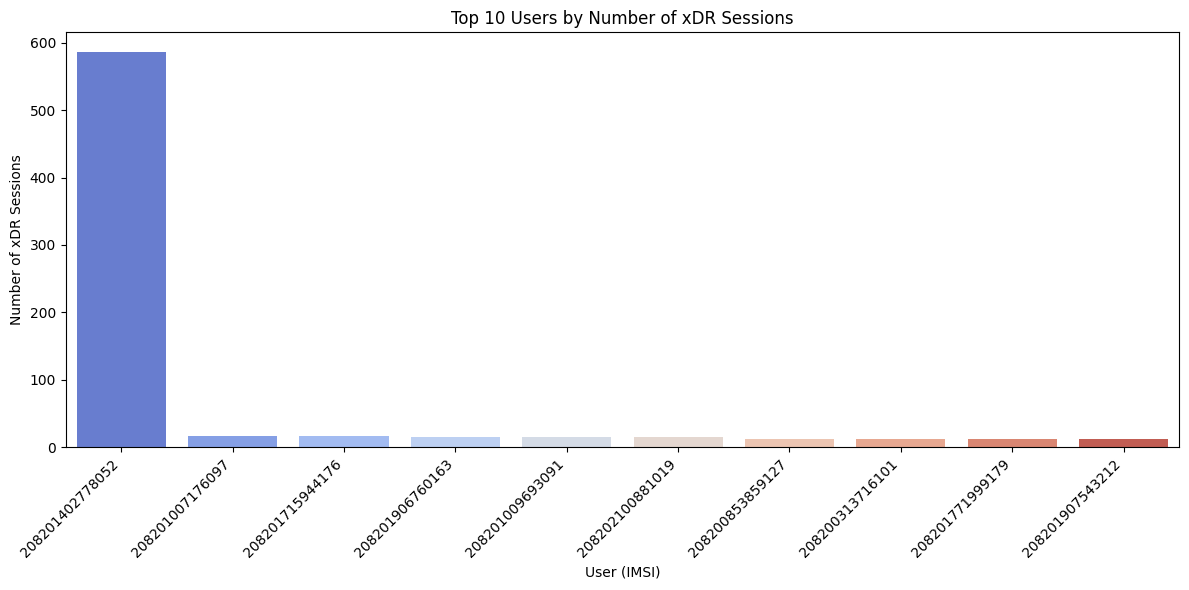

2024-12-25 22:58:48.726 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:58:49.134 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:58:49.135 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


['208200312952046',
 '208201771541102',
 '208201909782212',
 '208200314633189',
 '208201713886202',
 '208201716606045',
 '208200314018110',
 '208201715800193',
 '208201715083205',
 '208201771444109',
 '208201771632098',
 '208201907766187',
 '208201546908212',
 '208201446170206',
 '208201544890064',
 '208201008711696',
 '208201713945076',
 '208201449616022',
 '208201908832066',
 '208201402542100',
 '208201402524015',
 '208201714096175',
 '208201715264917',
 '208201401731175',
 '208201008482061',
 '208201715798143',
 '208201711934129',
 '208201546002060',
 '208200854611229',
 '208201402123134',
 '208201714662009',
 '208201713290067',
 '208201903860083',
 '208200314183056',
 '208201545029292',
 '208201544359057',
 '208200851860023',
 '208201771744106',
 '208201007987017',
 '208201006305116',
 '208201908751139',
 '208201544335180',
 '208200852543058',
 '208201544049007',
 '208201715882254',
 '208201771654002',
 '208201008711008',
 '208201772006155',
 '208201008712049',
 '208201546500246',


In [30]:
# Get the top 10 users based on Number_of_xDR_Sessions
top_xdr_users = aggregated_data.nlargest(10, 'Number_of_xDR_Sessions')


# Call the plot_bar_chart function with the desired parameters
plot_bar_chart(
    data=top_xdr_users,
    x_col='IMSI',  # IMSI will be on the x-axis
    y_col='Number_of_xDR_Sessions',  # Number_of_xDR_Sessions will be on the y-axis
    x_label="User (IMSI)",  # Label for the x-axis
    y_label="Number of xDR Sessions",  # Label for the y-axis
    title="Top 10 Users by Number of xDR Sessions",  # Title of the chart
    color_palette="coolwarm",  # Color palette for the bars
    horizontal=False  # Use vertical bars
)


outlier_imsis

In [31]:
top_xdr_users[['IMSI', 'Number_of_xDR_Sessions']].head(10)

,IMSI,Number_of_xDR_Sessions
36781,208201402778052,586
15895,208201007176097,17
71849,208201715944176,17
88187,208201906760163,16
25251,208201009693091,15
101057,208202100881019,15
10550,208200853859127,13
2964,208200313716101,12
84619,208201771999179,12
89687,208201907543212,12


Total Data Volume per User

/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:334: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=color_palette, ax=ax)
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability


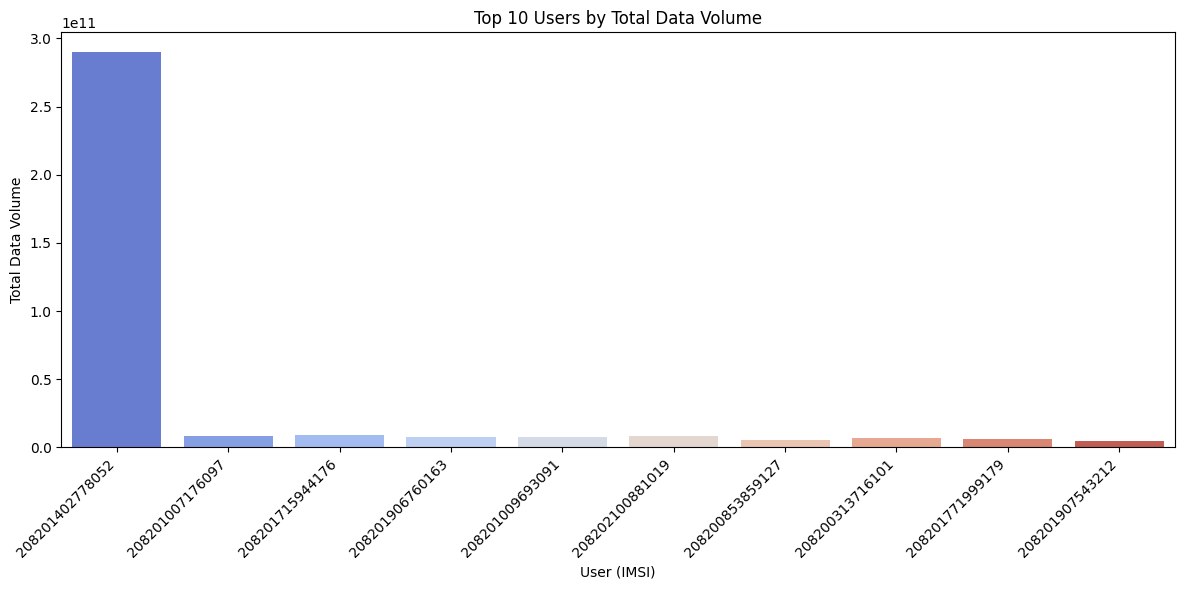

2024-12-25 23:12:28.191 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:12:28.641 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:12:28.642 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [52]:
# Top 10 users by total data volume
top_data_users = aggregated_data.nlargest(10, 'Total_Data_Volume')

plot_bar_chart(
    data=top_xdr_users,
    x_col='IMSI',  # IMSI will be on the x-axis
    y_col='Total_Data_Volume',  # Number_of_xDR_Sessions will be on the y-axis
    x_label="User (IMSI)",  # Label for the x-axis
    y_label="Total Data Volume",  # Label for the y-axis
    title="Top 10 Users by Total Data Volume",  # Title of the chart
    color_palette="coolwarm",  # Color palette for the bars
    horizontal=False  # Use vertical bars
)


In [33]:
top_data_users[['IMSI', 'Total_Data_Volume']].head(10)

,IMSI,Total_Data_Volume
36781,208201402778052,2.899904e+11
71849,208201715944176,8.846226e+09
101057,208202100881019,8.514774e+09
15895,208201007176097,8.499621e+09
25251,208201009693091,7.891111e+09
88187,208201906760163,7.705863e+09
35405,208201402604136,7.308501e+09
2964,208200313716101,7.132371e+09
62320,208201714300272,6.872018e+09
49823,208201545274157,6.540899e+09


Application-wise Data Usage

/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:344: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data.index.astype(str), y=data.values, palette=color_palette, ax=ax)
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability


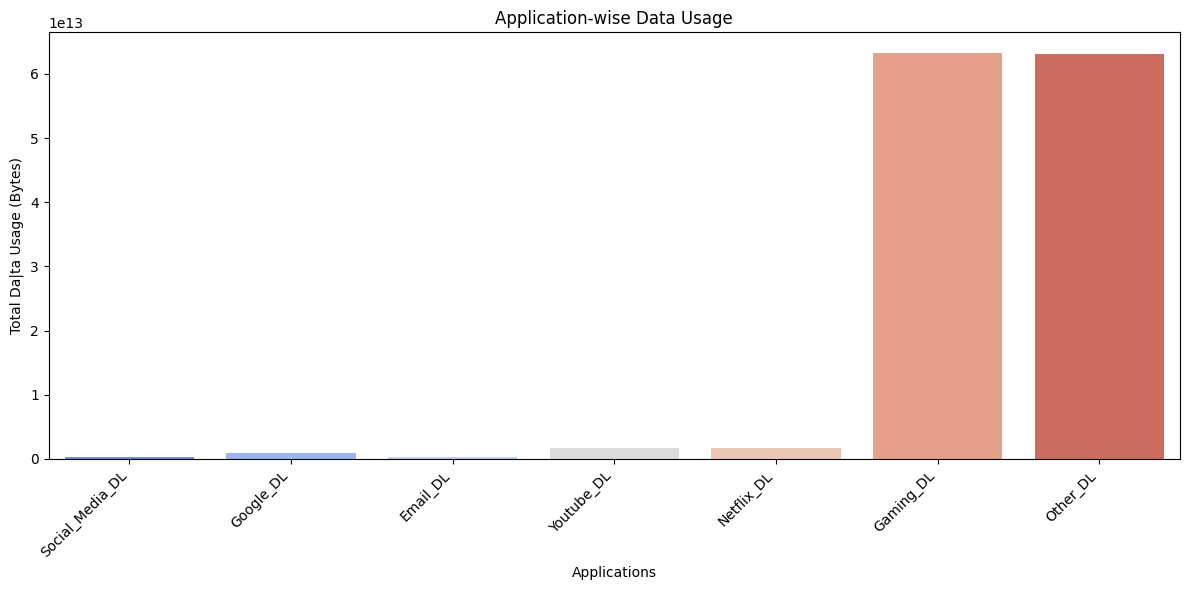

2024-12-25 23:14:31.373 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:14:31.709 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:14:31.710 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [53]:
# Aggregating application-wise data
application_data = aggregated_data[['Social_Media_DL', 'Google_DL', 'Email_DL', 'Youtube_DL', 'Netflix_DL', 'Gaming_DL', 'Other_DL']].sum()

plot_bar_chart(
    data=application_data,
    x_col='IMSI',  # IMSI will be on the x-axis
    y_col='Total_Data_Volume',  # Number_of_xDR_Sessions will be on the y-axis
    x_label="Applications",  # Label for the x-axis
    y_label="Total Da|ta Usage (Bytes)",  # Label for the y-axis
    title="Application-wise Data Usage",  # Title of the chart
    color_palette="coolwarm",  # Color palette for the bars
    horizontal=False  # Use vertical bars
)


/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:334: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=color_palette, ax=ax)
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability


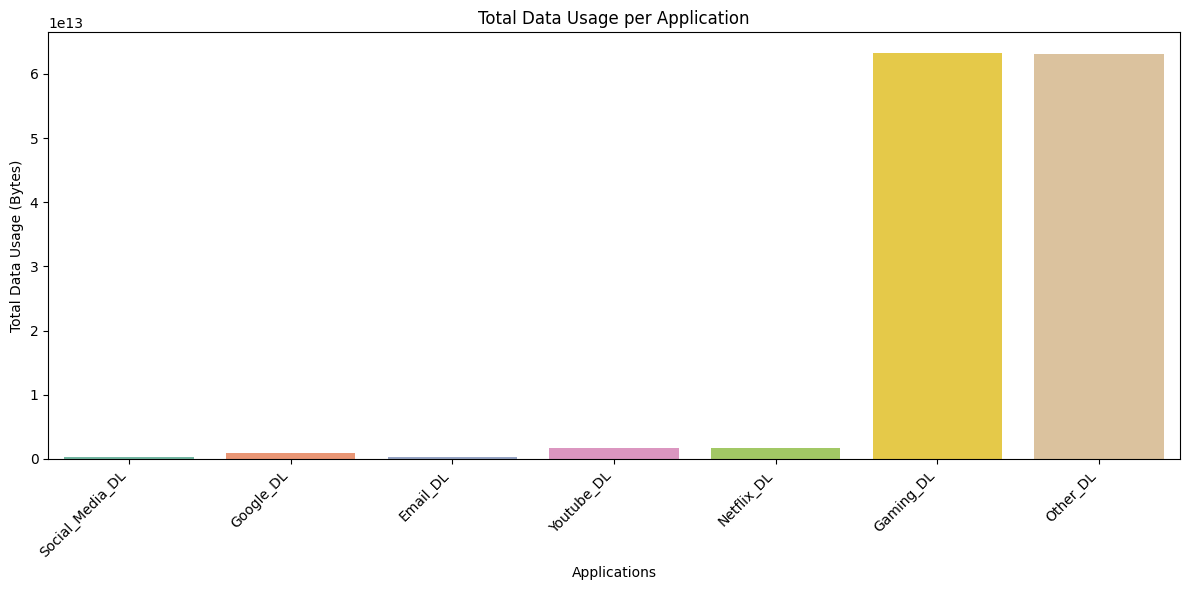

2024-12-25 22:59:06.504 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:59:06.886 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:59:06.887 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [35]:
application_data = aggregated_data[['Social_Media_DL', 'Google_DL', 'Email_DL', 'Youtube_DL', 'Netflix_DL', 'Gaming_DL', 'Other_DL']].sum()

if isinstance(application_data, pd.Series):
    application_data = application_data.reset_index()
    application_data.columns = ['Application', 'Data Usage']

# Call the plot_bar_chart function
plot_bar_chart(
    data=application_data,
    x_col='Application',          # Column to use for the x-axis
    y_col='Data Usage',           # Column to use for the y-axis
    title="Total Data Usage per Application",
    x_label="Applications",       # Label for x-axis
    y_label="Total Data Usage (Bytes)",  # Label for y-axis
    color_palette="Set2",         # Choose your color palette
    horizontal=False              # False for vertical bars
)


In [36]:
application_data.head(10)


,Application,Data Usage
0,Social_Media_DL,2.693001e+11
1,Google_DL,8.626186e+11
2,Email_DL,2.687611e+11
3,Youtube_DL,1.745123e+12
4,Netflix_DL,1.744039e+12
5,Gaming_DL,6.330713e+13
6,Other_DL,6.316550e+13


Session Duration Distribution

/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:334: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=color_palette, ax=ax)
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability


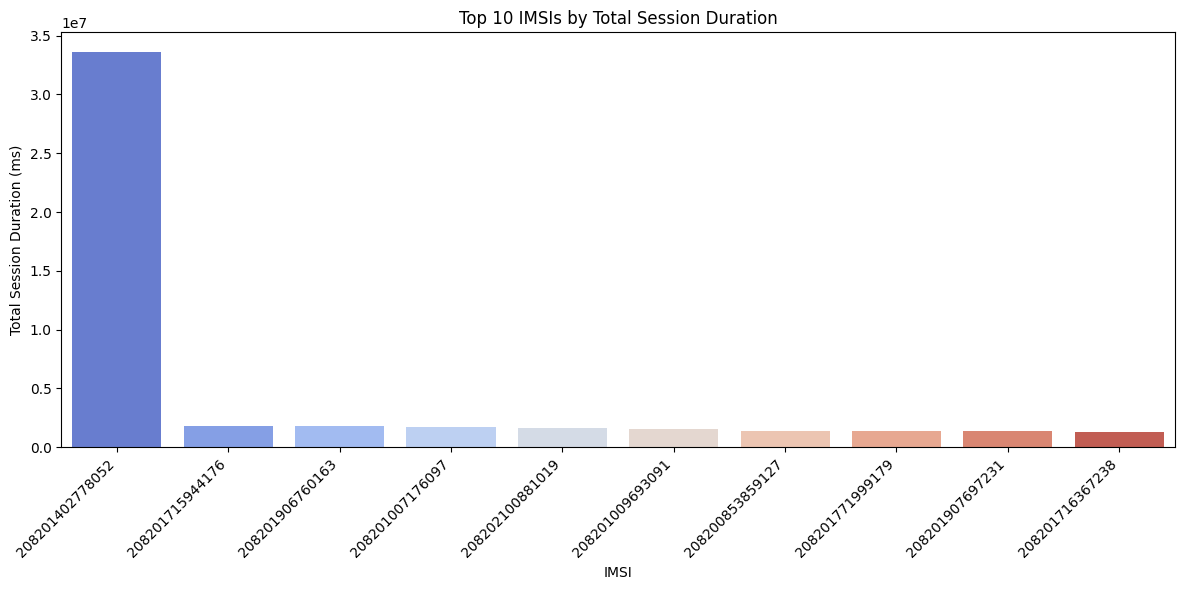

2024-12-25 22:59:12.672 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:59:13.079 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:59:13.080 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [37]:
# Aggregate the data by IMSI and calculate the sum of Total_Session_Duration for each IMSI
aggregated_imsi_data = aggregated_data.groupby('IMSI')['Total_Session_Duration'].sum().reset_index()

# Sort the data to get the top 10 IMSIs by Total_Session_Duration
top_10_imsi_data = aggregated_imsi_data.nlargest(10, 'Total_Session_Duration')

# Call plot_bar_chart function with the top 10 IMSIs and their total session durations
plot_bar_chart(
    data=top_10_imsi_data,
    x_col='IMSI',  # IMSI on the x-axis
    y_col='Total_Session_Duration',  # Total Session Duration on the y-axis
    title="Top 10 IMSIs by Total Session Duration",
    x_label="IMSI",
    y_label="Total Session Duration (ms)",
    color_palette="coolwarm",  # Choose your preferred color palette
    horizontal=False  # Horizontal bars
)


Total Session duraction Per User

In [38]:
aggregated_imsi_data.head(10)

,IMSI,Total_Session_Duration
0,204047108489451,104608.438950
1,204080810288647,104608.438950
2,208200101016140,86019.000000
3,208200101127285,86254.000000
4,208200101148045,193907.613676
5,208200101148074,13835.000000
6,208200101148075,222066.447166
7,208200101148136,232058.000000
8,208200101148139,86399.000000
9,208200101148152,136356.000000


In [39]:
aggregated_imsi_data.describe()

,Total_Session_Duration
count,1.072650e+05
mean,1.194708e+05
std,1.362515e+05
min,7.142000e+03
25%,7.041100e+04
50%,9.285245e+04
75%,1.535050e+05
max,3.359534e+07


Total downlaod and upload per user

In [40]:
# Aggregating Total Download Data and Total Upload Data by IMSI (User)
download_upload_data = aggregated_data[['IMSI', 'Total_Download_Data', 'Total_Upload_Data']]

# Display the aggregated data for all users
print("Total Download and Upload Data by User:")
download_upload_data[['IMSI', 'Total_Download_Data', 'Total_Upload_Data']]



Total Download and Upload Data by User:


,IMSI,Total_Download_Data,Total_Upload_Data
0,204047108489451,78697597.0,60456049.0
1,204080810288647,194828056.0,37295915.0
2,208200101016140,31376981.0,53794658.0
3,208200101127285,392918313.0,33583272.0
4,208200101148045,961767023.0,71325004.0
...,...,...,...
107260,208209850788090,688815403.0,33888182.0
107261,208209850788245,451173021.0,44692550.0
107262,208209850788283,307825104.0,30355487.0
107263,208252167239575,800629358.0,45083854.0


/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:387: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  data.set_index(x_col)[y_cols].plot(kind='bar', stacked=True, figsize=figsize, cmap='viridis', color=colors, ax=ax)
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:387: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  data.set_index(x_col)[y_cols].plot(kind='bar', stacked=True, figsize=figsize, cmap='viridis', color=colors, ax=ax)


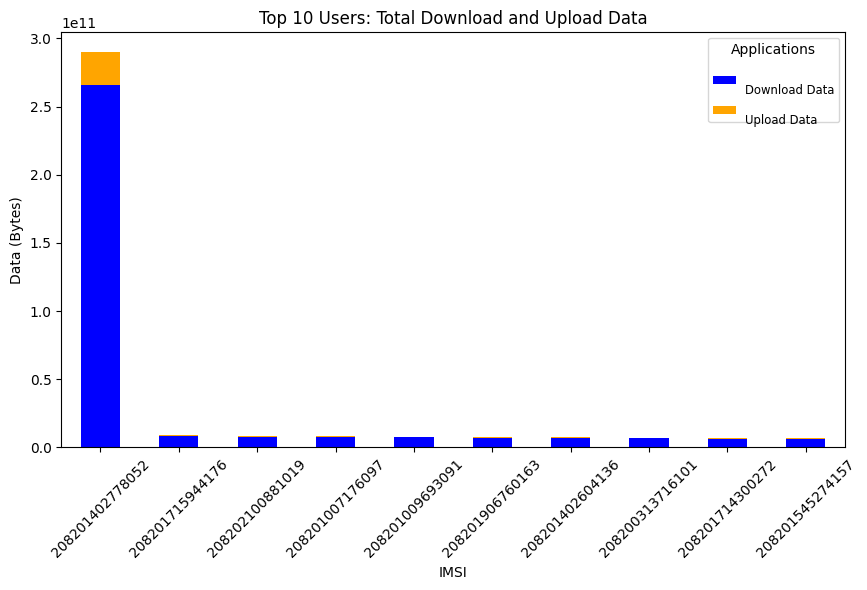

2024-12-25 22:59:24.271 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:59:24.679 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:59:24.679 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [41]:
# Sort the data based on Total Download Data and Total Upload Data in descending order
download_upload_data_sorted = download_upload_data.sort_values(by=['Total_Download_Data', 'Total_Upload_Data'], ascending=False)

# Select the top 10 users
top_10_users = download_upload_data_sorted.head(10)

# Reset index to avoid potential issues with x-axis plotting
top_10_users = top_10_users.reset_index(drop=True)  # Reset the index here

# Use the function to plot the stacked bar plot
plot_stacked_bar(
    data=top_10_users,
    x_col='IMSI',
    y_cols=['Total_Download_Data', 'Total_Upload_Data'],
    labels=['Download Data', 'Upload Data'],
    colors=['blue', 'orange'],
    title='Top 10 Users: Total Download and Upload Data',
    xlabel='IMSI',
    ylabel='Data (Bytes)',
    figsize=(10, 6),
    rotation=45,  # Rotate labels 45 degrees
    ha='right',  # Right-align the labels
    va='top'  # Align the labels at the top for better readability
)



In [58]:
download_upload_data_sorted.describe()

,Total_Download_Data,Total_Upload_Data
count,1.072650e+05,1.072650e+05
mean,6.357803e+08,5.746389e+07
std,9.330632e+08,8.188811e+07
min,8.827082e+06,2.866892e+06
25%,3.148031e+08,3.639251e+07
50%,5.700628e+08,4.675613e+07
75%,8.070673e+08,6.552324e+07
max,2.657735e+11,2.421693e+10


Engagement to applications per User

/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:387: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  data.set_index(x_col)[y_cols].plot(kind='bar', stacked=True, figsize=figsize, cmap='viridis', color=colors, ax=ax)


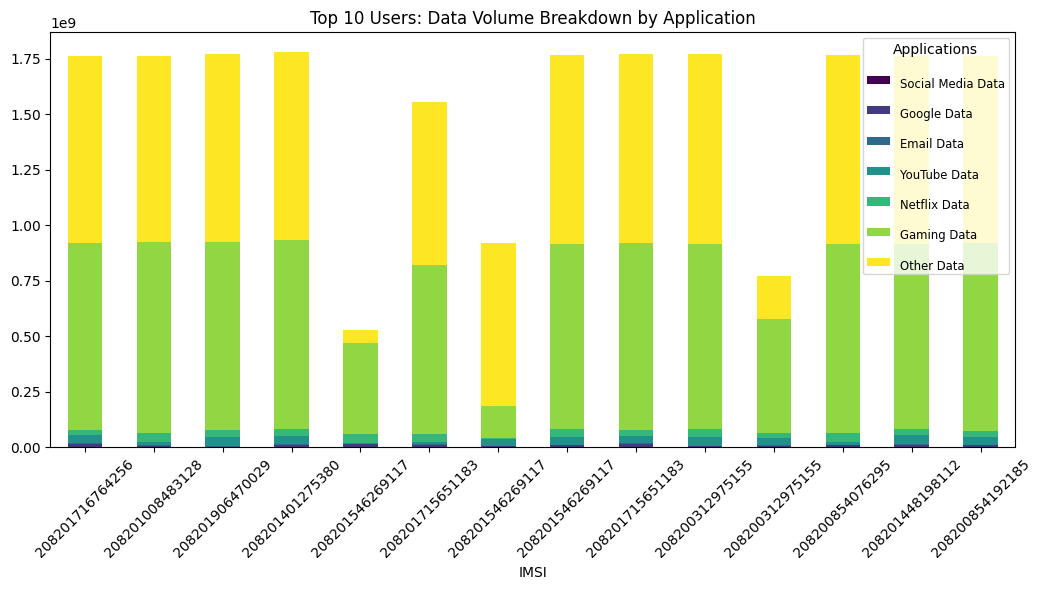

2024-12-25 22:59:27.919 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:59:28.407 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:59:28.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [42]:
# data preparation 
telecom_data['Total_Social_Media_Data'] = telecom_data['Social Media DL (Bytes)'] + telecom_data['Social Media UL (Bytes)']
telecom_data['Total_Google_Data'] = telecom_data['Google DL (Bytes)'] + telecom_data['Google UL (Bytes)']
telecom_data['Total_Email_Data'] = telecom_data['Email DL (Bytes)'] + telecom_data['Email UL (Bytes)']
telecom_data['Total_Youtube_Data'] = telecom_data['Youtube DL (Bytes)'] + telecom_data['Youtube UL (Bytes)']
telecom_data['Total_Netflix_Data'] = telecom_data['Netflix DL (Bytes)'] + telecom_data['Netflix UL (Bytes)']
telecom_data['Total_Gaming_Data'] = telecom_data['Gaming DL (Bytes)'] + telecom_data['Gaming UL (Bytes)']
telecom_data['Total_Other_Data'] = telecom_data['Other DL (Bytes)'] + telecom_data['Other UL (Bytes)']

# Select the columns for plotting: User and Total Data Volume for each application
data_volume_by_app = telecom_data[['IMSI', 
                                   'Total_Social_Media_Data', 
                                   'Total_Google_Data', 
                                   'Total_Email_Data', 
                                   'Total_Youtube_Data', 
                                   'Total_Netflix_Data', 
                                   'Total_Gaming_Data', 
                                   'Total_Other_Data']]

# Sort the data by the total data volume across all applications for each user (in descending order)
data_volume_by_app_sorted = data_volume_by_app.set_index('IMSI').sum(axis=1).sort_values(ascending=False).head(10)

# Get the top 10 users
top_10_users = data_volume_by_app.loc[data_volume_by_app['IMSI'].isin(data_volume_by_app_sorted.index)]

# Now use the plot_stacked_bar function with the correct parameters
plot_stacked_bar(
    data=top_10_users,
    title='Top 10 Users: Data Volume Breakdown by Application',
    x_col='IMSI',
    y_cols=[
        'Total_Social_Media_Data',
        'Total_Google_Data',
        'Total_Email_Data',
        'Total_Youtube_Data',
        'Total_Netflix_Data',
        'Total_Gaming_Data',
        'Total_Other_Data'
    ],
    labels=[
        'Social Media Data',
        'Google Data',
        'Email Data',
        'YouTube Data',
        'Netflix Data',
        'Gaming Data',
        'Other Data'
    ],
    figsize=(12, 6)
)


In [60]:
top_10_users.describe()

,Total_Social_Media_Data,Total_Google_Data,Total_Email_Data,Total_Youtube_Data,Total_Netflix_Data,Total_Gaming_Data,Total_Other_Data
count,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01,1.400000e+01
mean,2.528511e+06,7.332469e+06,2.489749e+06,2.853600e+07,2.958631e+07,7.342874e+08,7.281969e+08
std,8.798715e+05,3.276658e+06,9.559535e+05,1.187391e+07,8.960858e+06,2.198665e+08,2.596243e+08
min,6.319150e+05,1.766342e+06,1.213064e+06,3.083075e+06,5.918292e+06,1.431512e+08,5.881247e+07
25%,2.054354e+06,5.361356e+06,1.678268e+06,1.941619e+07,2.461437e+07,7.798667e+08,7.618806e+08
50%,2.650791e+06,7.171759e+06,2.679265e+06,3.407525e+07,3.124047e+07,8.400821e+08,8.444612e+08
75%,3.308540e+06,9.119790e+06,3.098564e+06,3.689432e+07,3.502492e+07,8.477066e+08,8.473614e+08
max,3.562888e+06,1.278346e+07,4.218120e+06,3.922459e+07,4.028264e+07,8.585627e+08,8.563794e+08


Data Volume vs. Number of Sessions (Correlation Analysis)

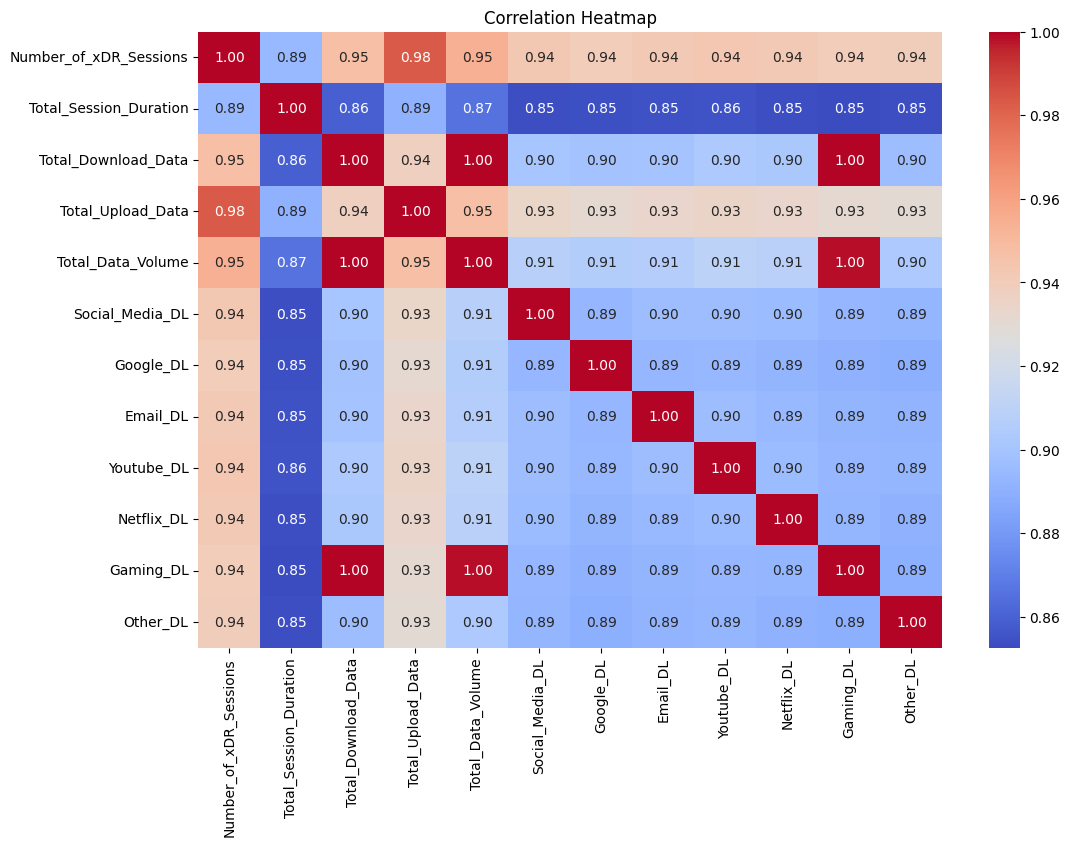

2024-12-25 22:59:31.774 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:59:32.561 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:59:32.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [43]:
columns = ['Number_of_xDR_Sessions', 
           'Total_Session_Duration', 
           'Total_Download_Data', 
           'Total_Upload_Data', 
           'Total_Data_Volume', 
           'Social_Media_DL', 
           'Google_DL', 
           'Email_DL', 
           'Youtube_DL', 
           'Netflix_DL', 
           'Gaming_DL', 
           'Other_DL']

# Calling the function with your data and selected columns
plot_correlation_heatmap(aggregated_data, columns)


In [44]:
high_correlation_pairs = find_high_correlation_pairs(aggregated_data, threshold=0.80)
# print("Pairs of variables with correlation above 0.80:\n", high_correlation_pairs)


high_correlation_pairs

,Variable 1,Variable 2,Correlation
19,Number_of_xDR_Sessions,Total_Session_Duration,0.894395
20,Number_of_xDR_Sessions,Total_Download_Data,0.947203
21,Number_of_xDR_Sessions,Total_Upload_Data,0.983014
22,Number_of_xDR_Sessions,Total_Data_Volume,0.954473
23,Number_of_xDR_Sessions,Social_Media_DL,0.942657
...,...,...,...
185,Gaming_DL,Other_DL,0.888970
186,Gaming_DL,Other_UL,0.893713
187,Gaming_UL,Other_DL,0.887153
188,Gaming_UL,Other_UL,0.891542


Variable Transformations: Segment Users into the Top Five Decile Classes Based on Total Duration

In [45]:
# Calculate total session duration per user
telecom_data['Total Duration'] = telecom_data.groupby('IMSI')['Dur. (ms)'].transform('sum')

# Calculate deciles based on total duration
deciles = pd.qcut(telecom_data['Total Duration'], 10, labels=False)  # 10 equal-sized bins

# Add decile classification to the DataFrame
telecom_data['Duration Decile'] = deciles

# Compute the total data (DL + UL) per decile
telecom_data['Total DL + UL'] = telecom_data['Total DL (Bytes)'] + telecom_data['Total UL (Bytes)']
total_data_per_decile = telecom_data.groupby('Duration Decile')['Total DL + UL'].sum().reset_index()

print(total_data_per_decile)


   Duration Decile  Total DL + UL
0                0   7.435253e+12
1                1   7.432278e+12
2                2   8.421479e+12
3                3   6.512391e+12
4                4   7.441028e+12
5                5   7.443622e+12
6                6   7.428035e+12
7                7   7.439802e+12
8                8   7.697999e+12
9                9   7.108947e+12


In [46]:
total_data_per_decile = calculate_decile(telecom_data)
print(total_data_per_decile)


   Duration Decile  Total DL + UL
0                0   7.435253e+12
1                1   7.432278e+12
2                2   8.421479e+12
3                3   6.512391e+12
4                4   7.441028e+12
5                5   7.443622e+12
6                6   7.428035e+12
7                7   7.439802e+12
8                8   7.697999e+12
9                9   7.108947e+12


/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:334: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=color_palette, ax=ax)
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability


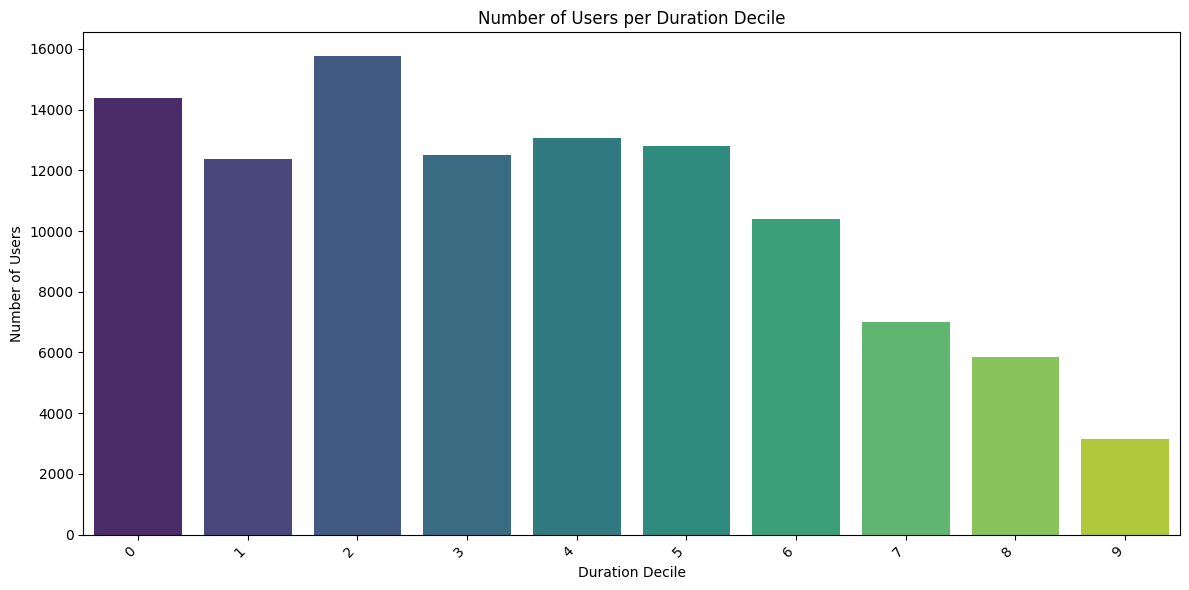

2024-12-25 22:59:57.035 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:59:57.414 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 22:59:57.415 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [47]:
# Count the number of users in each decile
user_count_by_decile = telecom_data.groupby('Duration Decile')['IMSI'].nunique().reset_index()

# Call the plot_bar_chart function to visualize the count of users by decile
plot_bar_chart(data=user_count_by_decile, x_col='Duration Decile', y_col='IMSI', 
               x_label='Duration Decile', y_label='Number of Users', title='Number of Users per Duration Decile', color_palette='viridis')


Dimentionality Reduction

In [48]:
top_10_features = get_important_features(telecom_data, n_top_features=10)
print("Top 10 Most Important Features based on PCA Loadings:")
print(top_10_features)


Top 10 Most Important Features based on PCA Loadings:
                                                                           Feature  \
Nb of sec with Vol DL < 6250B                        Nb of sec with Vol DL < 6250B   
DL TP > 1 Mbps (%)                                              DL TP > 1 Mbps (%)   
10 Kbps < UL TP < 50 Kbps (%)                        10 Kbps < UL TP < 50 Kbps (%)   
Nb of sec with 125000B < Vol DL                    Nb of sec with 125000B < Vol DL   
Nb of sec with 1250B < Vol UL < 6250B        Nb of sec with 1250B < Vol UL < 6250B   
Nb of sec with 31250B < Vol DL < 125000B  Nb of sec with 31250B < Vol DL < 125000B   
Avg RTT DL (ms)                                                    Avg RTT DL (ms)   
Youtube DL (Bytes)                                              Youtube DL (Bytes)   
50 Kbps < DL TP < 250 Kbps (%)                      50 Kbps < DL TP < 250 Kbps (%)   
DL TP < 50 Kbps (%)                                            DL TP < 50 Kbps (%)   


/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:334: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data[x_col], y=data[y_col], palette=color_palette, ax=ax)
/home/samrawit/Kifya AIM/Challenge 2/TellcoTelecomGrowthAnalysis/scripts/plot.py:353: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate labels for better readability


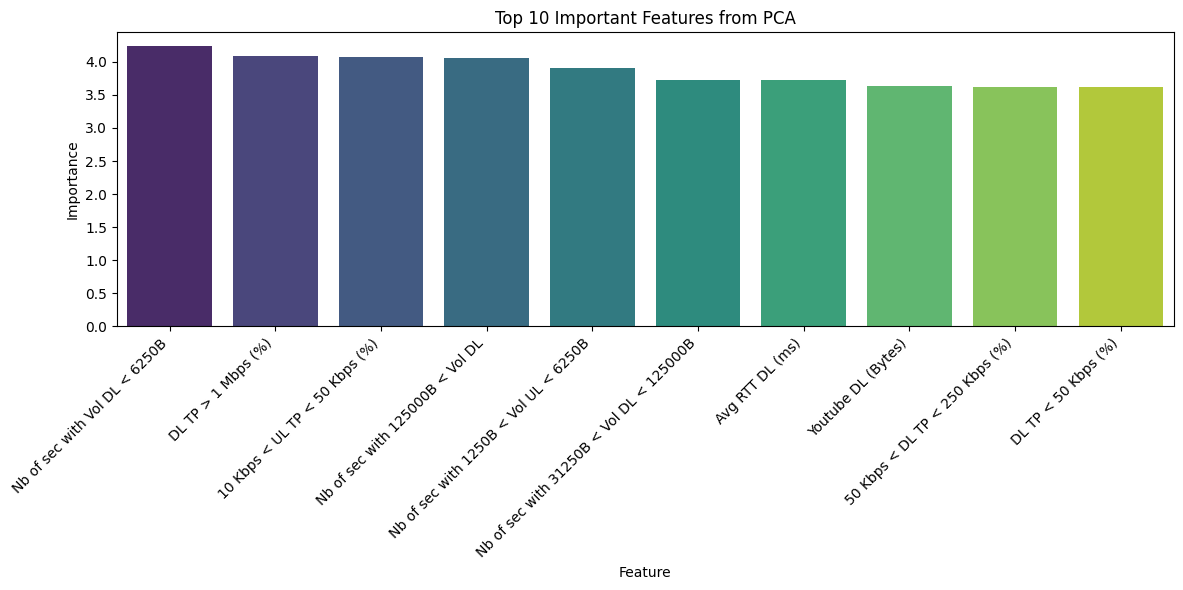

2024-12-25 23:00:05.591 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:00:05.984 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 23:00:05.985 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [49]:

# Call the plot_bar_chart function to visualize the top 10 important features based on PCA loadings
plot_bar_chart(data=top_10_features.head(10), x_col='Feature', y_col='Importance', 
               x_label='Feature', y_label='Importance', title='Top 10 Important Features from PCA', color_palette='viridis')
